In [1]:
from sage.combinat.vector_partition import IntegerVectorsIterator
from collections import Counter
from IPython.display import Markdown

from functools import reduce
import itertools


def clr_print(t,color='red'):
    display(Markdown('<span style="color:'+str(color)+'">' + t + '</span>'))

def size_print(t, size = '4em'):
    display(Markdown('<span style="font-size:'+str(size)+'">' + t + '</span>'))

class QuiverRoots(SageObject):
    """
    Keeps track of roots, decompositions for 
    quiver varieties with stability parameters
    based on the Crawley-Boevey description
    """
    def __init__(self, C):
        """
        Initialize for a quiver with Cartan matrix C
        This is required to include the framing vertex infty 
        after reduction to the W= 0 case
        """
        self.C = C
        self.rk = C.dimensions()[0]
        self.v = VectorSpace(QQ,self.rk, inner_product_matrix=C )
        self.pair = lambda a,b : vector(a)*C*vector(b)
        self.p = lambda a : 1 - 1/2*self.pair(a,a)
        
    def unframed_stab(self,v, θ):
        """
        given a len n-1 stability vector θ for framed quiver reps,
        spits out (-θ(v), θ),
        which is the appropriate stability condition for the CB reduction to 
        unframed case
        """
        return(vector([-vector(v[1:])*vector(θ)] + list(θ)))
        
    def has_connected_support(self, v):
        """
        checks if dimension vector v has connected support on the
        dyinkin diagram associated to C
        """
        listv = list(v)
        support = [i for i in range(self.rk) if listv[i] != 0]
        a_component = set([support[0]])
        checked = a_component
        unchecked = set(support[1:])
        adjacents_in_support = lambda i : [a for a in range(self.rk) if 
                                           a != i and 
                                           C[i,a] != 0 and 
                                           a in support]
        current = support[0]
        while len(checked) < len(support):
            checked.add(current)
            unchecked.discard(current)
            a_component.update(adjacents_in_support(current))
            unchecked_in_cpt = unchecked.intersection(a_component)
            if len(unchecked_in_cpt) == 0:
                break
            current = unchecked_in_cpt.pop()
        if len(a_component) == len(support):
            return(True)
        else:
            return(False)
        
        
    def R_v(self, v, connected_support = True):
        """
        returns positive roots less than v, without the connected 
        support condition if  connected_support is set to False
        """
        if connected_support == True:
            return(α for α in IntegerVectorsIterator(list(v)) if self.pair(vector(α), vector(α)) <= 2 and vector(α) != 0 and 
                  self.has_connected_support(α))
        else: 
            return(α for α in IntegerVectorsIterator(list(v)) if self.pair(α, α) <= 2)
    
    def R_θ_v(self,θ,v, connected_support = True):
        """
        Returns positive roots α less than v, with θ(α) = 0 
        again without connected support condition if  connected_support is set to False
        """
        rv = self.R_v(v)
        return([α for α in rv if vector(θ)*vector(α) == 0])
    
    def candidate_decompositions(self, θ, α):
        """
        Returns vector partitions of α
        such that each part is in R_θ
        """
        VPs = VectorPartitions(α)
        def each_part_in_R_θ(l):
            for p in l:
                if vector(θ)*vector(p) != 0:
                    return(False)
            return(True)
        return(vp for vp in VPs if each_part_in_R_θ(vp))
    
    def Σ_θ_v(self, θ, v):
        """
        Returns real possible decomposition factor options
        consistent with 3.10 Bellamy-Craw p 19
        of roots less than v
        the connected support condition is used
        """
        p = self.p
        def in_Σ(α):
            cd = list(self.candidate_decompositions(θ, α))
            for bs in cd:
                if len(bs) > 1 and (sum(p(β) for β in bs) >= p(α)):
                    return(False)
            return(True)
        return(α for α in self.R_θ_v(θ, v) if in_Σ(α))
    
    def uncollected_decompositions(self, θ, v):
        """
        Returns vector partitions of v all of whose 
        parts are in Σ_θ_v
        A decomposition has some of the same parts collected
        the connected support condition is used
        """
        candidates = self.candidate_decompositions(θ, v)
        Σ = list(self.Σ_θ_v(θ, v))
        #print(f"Σ = {Σ}")
        def each_part_in_Σ(l):
            for p in l:
                if not (p in Σ):
                    return(False)
            return(True)
        return(d for d in candidates if each_part_in_Σ(d))
    
    def completely_collected_decompositions(self,θ,v):
        """
        returns lists of tuples
        [(β_1,n_1), ..., (β_k, n_k)]
        giving decompositions where 
        i \neq j implies β_i \neq β_j
        """
        out = []
        for d in self.uncollected_decompositions(θ,v):
            td = [tuple(a) for a in d]
            out.append(list(Counter(td).items()))
        return(out)
            
        return(list(Counter(self.uncollected_decompositions(θ, v)).items()))
    
    def decompositions(self, θ, v):
        r"""
        returns all decompositons 
        [(β_1,n_1), ..., (β_k, n_k)]
        corresponding to 
        $\oplus_i \beta_i^{\oplus n_i}$
        as dimension vectors.
        c.f. Bellamy-Craw p.19
        """
        completely_collected = self.completely_collected_decompositions(θ, v)
        out = []
        for decomp in completely_collected:
            imaginary_parts = [(β,n) for (β,n) in decomp if self.p(β) > 0]
            unrefined_reals = [(β, n) for (β, n) in decomp if self.p(β) <= 0]
            new = unrefined_reals
            refinements_of_βn = lambda β, n: [[(β, λi) for λi in λ] for λ in Partitions(n)] # lists refinements of this summand
            endings = [list(itertools.chain(*a)) for a in itertools.product(*[refinements_of_βn(β, n) for (β, n) in imaginary_parts])]
            out += [new + e for e in endings]
        return(out)
        
    
    def stratum_dimension(self, decomp):
        """
        takes a decomposition
        [β_1^n_1, ..., β_k^n_k]
        given as a list of tupes
        [(β_1,n_1), ..., (β_k, n_k)]
        and returns
        2*sum (p(β_i)) 
        the dimension of the stratum. 
        If β_i is REAL it can only show up once for this formula
        to make sense
        """
        βs = [β for (β, n) in decomp]
        for β in [β for β in βs if βs.count(β) > 1]:
            assert self.p(β) > 0, "real roots β in decomposition must be unique"
        return(2*sum(self.p(β) for β in βs))
    
    def stratum_ext_quiver(self, decomp, θ, θs, framed = True):
        r"""
        gives the information about the local 
        structure of the singularity at the condition 
        θ

        INPUT : 

        - ``decomp`` -- [(β_1,n_1), ..., (β_k, n_k)]; the decomposition
          describing the stratum

        - ``θ`` -- vector; gives stability condition on the wall
        
        - ``θs`` -- list of vectors; which stability conditions adjacent to 
          this wall we are considering
          
        - ``framed`` -- bool (default: True); Whether to use the framed equivalent
          quiver or the Crawley-Boevey one

        OUTPUT: (Q,v,l, [ρs]) where Q is the graph of th ext quiver
         v is the dimension vector
         l is an integer 
         and ρ_i in the list [ρs] is 
         the analogue of θi so the map M_θ_i -> M_θ is analytically locall
         C^l x M_ρ(Q,v) -> M_0(Q,v) at a point of M_θ in the stratum with decomposition
         decomp

        EXAMPLES: 

        This exmaple shows an example of the above, finding all
        strata for affine A_1 quiver and a v = (1,2) w = (1,0) ::

            sage: C = Matrix([[2,-1,0],[-1,2,-2],[0,-2,2]])
            sage: QR = QuiverRoots(C)
            sage: v = (1,1,2)
            sage: θ = QR.unframed_stab(v, (1,0))
            sage: for dc in QR.decompositions(θ, v):
            sage:     print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
            sage:     (Q,v,l,q) = QR.stratum_ext_quiver(dc, θ, [])
            sage:     print(f"v = {v}, l = {l}")
            sage:     show(Q, figsize=1)
            stratum [((0, 0, 1), 2), ((1, 1, 0), 1)] has dim 0
            v = [1, 2], l = 0
            <Graphics object> 
            stratum [((0, 0, 1), 1), ((1, 1, 1), 1)] has dim 2
            v = [1, 1], l = 2
            <Graphics object> 

        NOTE ::

            this code doesn't spit out [ρi] yet 
            We spit out the dimension v of the CB "unframed" quvier 
            even if framed is True
        """
        dc = sorted(decomp, reverse=True) #makes sure vertex 1 is framing vertex b/c first element will be
        #(1,...),  others (0,...)
        k = len(dc)
        if framed == False:
            self_loops = lambda i : [lbl(i)]*int(self.p(dc[i][0])) if i != 0 else []
            edges_at = lambda i :  self_loops(i) + list(itertools.chain(*([lbl(j)]*(-self.pair(dc[i][0], dc[j][0]) ) for j in range(k) if j != i)))
            lbl = lambda t : '∞' if t == 0 else t
            Q = Graph({lbl(i):edges_at(i) for i in range(k)})
            l = 2*self.p(dc[0][0])
            v = [n for (β, n) in dc]
            ρs = []
            return((Q,v,l,ρs))
        else:
            v = [n for (β, n) in dc]
            lbl = lambda i : "v_"+ str(i) + "=" + str(v[i])
            unframing_edges = lambda i : [lbl(i)]*int(self.p(dc[i][0])) + list(itertools.chain(*([lbl(j)]*(-self.pair(dc[i][0], dc[j][0]) ) for j in range(1,k) if j != i)))
            framing_g_dict = {str(-self.pair(dc[0][0], dc[i][0])) + "dim framing" : [lbl(i)] for i in range(1,k)}
            framing_g_dict.update({lbl(i):unframing_edges(i) for i in range(1,k)})
            Q = Graph(framing_g_dict)
            l = 2*self.p(dc[0][0])
            ρs = []
            return((Q,v,l,ρs))
    
    def generic_in_R_perp(self, v, R):
        pass
    

clr_print('uh oh', 'red')

<span style="color:red">uh oh</span>

## Visializing some '2d' (i.e. 2+2D?) affine quiver root data

<span style="font-size:3em">v = (1, 4, 3, 3)</span>

dimension = 6
Cnf . v = (-1, -1)
v = (1, 4, 3, 3),simple = (0, 0, 1), θ = (-32, 33, 0), stratadims = 
[([((0, 0, 0, 1), 1), ((1, 4, 3, 2), 1)], 2), ([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (0, 1, 0), θ = (-32, 0, 33), stratadims = 
[([((0, 0, 1, 0), 1), ((1, 4, 2, 3), 1)], 2), ([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (1, 0, 1), θ = (-33, 1, 33), stratadims = 
[([((0, 1, 0, 1), 1), ((1, 3, 3, 2), 1)], 4), ([((1, 4, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 1, 0, 1), 1), ((1, 3, 3, 2), 1)] has divisorial dim 4</span>

v = (1, 4, 3, 3),simple = (1, 1, 0), θ = (-33, 33, 1), stratadims = 
[([((0, 1, 1, 0), 1), ((1, 3, 2, 3), 1)], 4), ([((1, 4, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 1, 1, 0), 1), ((1, 3, 2, 3), 1)] has divisorial dim 4</span>

v = (1, 4, 3, 3),simple = (1, 1, 2), θ = (-31, 33, -1), stratadims = 
[([((0, 1, 1, 2), 1), ((1, 3, 2, 1), 1)], 0), ([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (1, 2, 1), θ = (-31, -1, 33), stratadims = 
[([((0, 1, 2, 1), 1), ((1, 3, 1, 2), 1)], 0), ([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (2, 1, 2), θ = (-34, 2, 33), stratadims = 
[([((0, 2, 1, 2), 1), ((1, 2, 2, 1), 1)], 2), ([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (2, 2, 1), θ = (-34, 33, 2), stratadims = 
[([((0, 2, 2, 1), 1), ((1, 2, 1, 2), 1)], 2), ([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (2, 2, 3), θ = (-30, 33, -2), stratadims = 
[([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (2, 3, 2), θ = (-30, -2, 33), stratadims = 
[([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (3, 2, 3), θ = (-35, 3, 33), stratadims = 
[([((0, 3, 2, 3), 1), ((1, 1, 1, 0), 1)], 0), ([((1, 4, 3, 3), 1)], 6)]
v = (1, 4, 3, 3),simple = (3, 3, 2), θ = (-35, 33, 3), stratadims = 
[([((0, 3, 3, 2), 1), ((1, 1, 

/home/samuel/SageMath/local/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


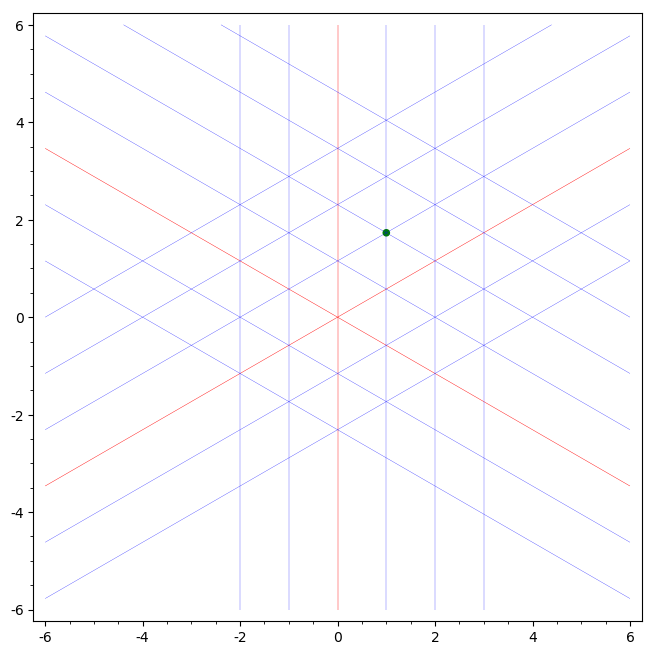

corresponding nδ = (1, 3, 3, 3):
v = (1, 3, 3, 3),simple = (0, 0, 1), θ = (-29, 30, 0), stratadims = 
[([((0, 0, 0, 1), 1), ((1, 3, 3, 2), 1)], 4), ([((1, 3, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 0, 0, 1), 1), ((1, 3, 3, 2), 1)] has divisorial dim 4</span>

v = (1, 3, 3, 3),simple = (0, 1, 0), θ = (-29, 0, 30), stratadims = 
[([((0, 0, 1, 0), 1), ((1, 3, 2, 3), 1)], 4), ([((1, 3, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 0, 1, 0), 1), ((1, 3, 2, 3), 1)] has divisorial dim 4</span>

v = (1, 3, 3, 3),simple = (1, 0, 1), θ = (-30, 1, 30), stratadims = 
[([((0, 1, 0, 1), 1), ((1, 2, 3, 2), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 1, 0), θ = (-30, 30, 1), stratadims = 
[([((0, 1, 1, 0), 1), ((1, 2, 2, 3), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 1, 2), θ = (-28, 30, -1), stratadims = 
[([((0, 1, 1, 2), 1), ((1, 2, 2, 1), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 2, 1), θ = (-28, -1, 30), stratadims = 
[([((0, 1, 2, 1), 1), ((1, 2, 1, 2), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 1, 2), θ = (-31, 2, 30), stratadims = 
[([((0, 2, 1, 2), 1), ((1, 1, 2, 1), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 2, 1), θ = (-31, 30, 2), stratadims = 
[([((0, 2, 2, 1), 1), ((1, 1, 1, 2), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 2, 3), θ = (-27, 30, -2), stratadims = 
[([((0, 2, 2, 3), 1), ((1, 1, 1, 0), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3,

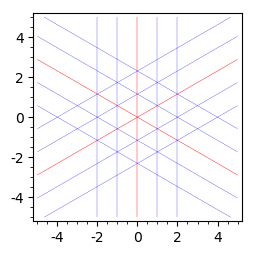

<span style="font-size:3em">v = (1, 3, 3, 3)</span>

dimension = 6
Cnf . v = (0, 0)
v = (1, 3, 3, 3),simple = (0, 0, 1), θ = (-29, 30, 0), stratadims = 
[([((0, 0, 0, 1), 1), ((1, 3, 3, 2), 1)], 4), ([((1, 3, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 0, 0, 1), 1), ((1, 3, 3, 2), 1)] has divisorial dim 4</span>

v = (1, 3, 3, 3),simple = (0, 1, 0), θ = (-29, 0, 30), stratadims = 
[([((0, 0, 1, 0), 1), ((1, 3, 2, 3), 1)], 4), ([((1, 3, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 0, 1, 0), 1), ((1, 3, 2, 3), 1)] has divisorial dim 4</span>

v = (1, 3, 3, 3),simple = (1, 0, 1), θ = (-30, 1, 30), stratadims = 
[([((0, 1, 0, 1), 1), ((1, 2, 3, 2), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 1, 0), θ = (-30, 30, 1), stratadims = 
[([((0, 1, 1, 0), 1), ((1, 2, 2, 3), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 1, 2), θ = (-28, 30, -1), stratadims = 
[([((0, 1, 1, 2), 1), ((1, 2, 2, 1), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 2, 1), θ = (-28, -1, 30), stratadims = 
[([((0, 1, 2, 1), 1), ((1, 2, 1, 2), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 1, 2), θ = (-31, 2, 30), stratadims = 
[([((0, 2, 1, 2), 1), ((1, 1, 2, 1), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 2, 1), θ = (-31, 30, 2), stratadims = 
[([((0, 2, 2, 1), 1), ((1, 1, 1, 2), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 2, 3), θ = (-27, 30, -2), stratadims = 
[([((0, 2, 2, 3), 1), ((1, 1, 1, 0), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3,

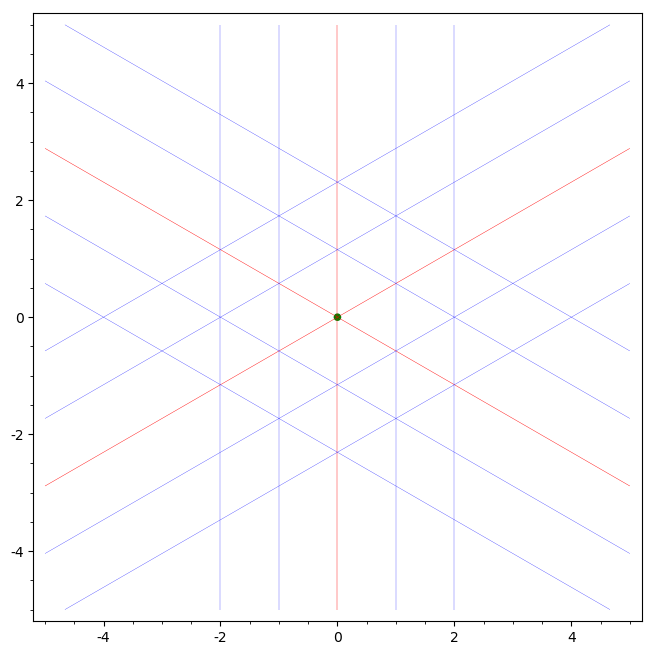

corresponding nδ = (1, 3, 3, 3):
v = (1, 3, 3, 3),simple = (0, 0, 1), θ = (-29, 30, 0), stratadims = 
[([((0, 0, 0, 1), 1), ((1, 3, 3, 2), 1)], 4), ([((1, 3, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 0, 0, 1), 1), ((1, 3, 3, 2), 1)] has divisorial dim 4</span>

v = (1, 3, 3, 3),simple = (0, 1, 0), θ = (-29, 0, 30), stratadims = 
[([((0, 0, 1, 0), 1), ((1, 3, 2, 3), 1)], 4), ([((1, 3, 3, 3), 1)], 6)]


<span style="color:red">stratum[((0, 0, 1, 0), 1), ((1, 3, 2, 3), 1)] has divisorial dim 4</span>

v = (1, 3, 3, 3),simple = (1, 0, 1), θ = (-30, 1, 30), stratadims = 
[([((0, 1, 0, 1), 1), ((1, 2, 3, 2), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 1, 0), θ = (-30, 30, 1), stratadims = 
[([((0, 1, 1, 0), 1), ((1, 2, 2, 3), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 1, 2), θ = (-28, 30, -1), stratadims = 
[([((0, 1, 1, 2), 1), ((1, 2, 2, 1), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (1, 2, 1), θ = (-28, -1, 30), stratadims = 
[([((0, 1, 2, 1), 1), ((1, 2, 1, 2), 1)], 2), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 1, 2), θ = (-31, 2, 30), stratadims = 
[([((0, 2, 1, 2), 1), ((1, 1, 2, 1), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 2, 1), θ = (-31, 30, 2), stratadims = 
[([((0, 2, 2, 1), 1), ((1, 1, 1, 2), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 3, 3),simple = (2, 2, 3), θ = (-27, 30, -2), stratadims = 
[([((0, 2, 2, 3), 1), ((1, 1, 1, 0), 1)], 0), ([((1, 3, 3, 3), 1)], 6)]
v = (1, 3,

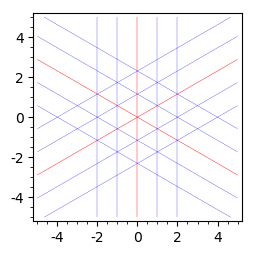

<span style="font-size:3em">v = (1, 3, 4, 3)</span>

dimension = 4
Cnf . v = (2, -1)
v = (1, 3, 4, 3),simple = (0, 0, 1), θ = (-32, 33, 0), stratadims = 
[([((0, 0, 0, 1), 1), ((1, 3, 4, 2), 1)], 0), ([((1, 3, 4, 3), 1)], 4)]
v = (1, 3, 4, 3),simple = (0, 1, 0), θ = (-32, 0, 33), stratadims = 
[([((0, 0, 1, 0), 2), ((1, 3, 2, 3), 1)], 4), ([((0, 0, 1, 0), 1), ((1, 3, 3, 3), 1)], 6)]
v = (1, 3, 4, 3),simple = (1, 0, 1), θ = (-33, 1, 33), stratadims = 
[([((1, 3, 4, 3), 1)], 4)]
v = (1, 3, 4, 3),simple = (1, 1, 0), θ = (-33, 33, 1), stratadims = 
[([((0, 1, 1, 0), 1), ((1, 2, 3, 3), 1)], 2), ([((1, 3, 4, 3), 1)], 4)]


<span style="color:red">stratum[((0, 1, 1, 0), 1), ((1, 2, 3, 3), 1)] has divisorial dim 2</span>

v = (1, 3, 4, 3),simple = (1, 1, 2), θ = (-31, 33, -1), stratadims = 
[([((1, 3, 4, 3), 1)], 4)]
v = (1, 3, 4, 3),simple = (1, 2, 1), θ = (-31, -1, 33), stratadims = 
[([((0, 1, 2, 1), 2), ((1, 1, 0, 1), 1)], 0), ([((0, 1, 2, 1), 1), ((1, 2, 2, 2), 1)], 4)]
v = (1, 3, 4, 3),simple = (2, 1, 2), θ = (-34, 2, 33), stratadims = 
[([((1, 3, 4, 3), 1)], 4)]
v = (1, 3, 4, 3),simple = (2, 2, 1), θ = (-34, 33, 2), stratadims = 
[([((0, 2, 2, 1), 1), ((1, 1, 2, 2), 1)], 0), ([((1, 3, 4, 3), 1)], 4)]
v = (1, 3, 4, 3),simple = (2, 2, 3), θ = (-30, 33, -2), stratadims = 
[([((1, 3, 4, 3), 1)], 4)]
v = (1, 3, 4, 3),simple = (2, 3, 2), θ = (-30, -2, 33), stratadims = 
[([((0, 2, 3, 2), 1), ((1, 1, 1, 1), 1)], 2), ([((1, 3, 4, 3), 1)], 4)]


<span style="color:red">stratum[((0, 2, 3, 2), 1), ((1, 1, 1, 1), 1)] has divisorial dim 2</span>

v = (1, 3, 4, 3),simple = (3, 4, 3), θ = (-29, -3, 33), stratadims = 
[([((0, 3, 4, 3), 1), ((1, 0, 0, 0), 1)], 0), ([((1, 3, 4, 3), 1)], 4)]
[(0, [0, 1]), (0, [1, 0]), (0, [1, 1]), (1, [-1, -1]), (1, [-1, 0]), (1, [0, -1]), (1, [0, 0]), (1, [0, 1]), (1, [1, 0]), (1, [1, 1]), (2, [-1, -1]), (2, [-1, 0]), (2, [0, -1]), (2, [0, 1]), (2, [1, 0]), (2, [1, 1]), (3, [1, 0])]


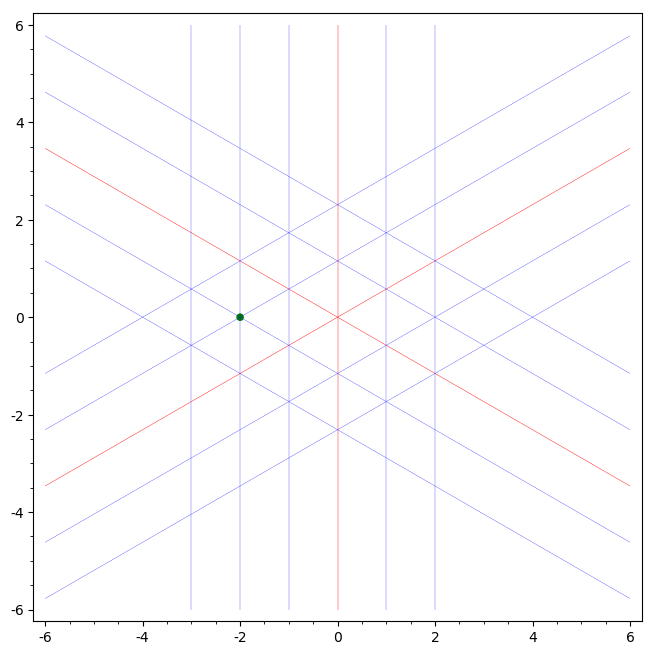

corresponding nδ = (1, 2, 2, 2):
v = (1, 2, 2, 2),simple = (0, 0, 1), θ = (-20, 21, 0), stratadims = 
[([((0, 0, 0, 1), 1), ((1, 2, 2, 1), 1)], 2), ([((1, 2, 2, 2), 1)], 4)]


<span style="color:red">stratum[((0, 0, 0, 1), 1), ((1, 2, 2, 1), 1)] has divisorial dim 2</span>

v = (1, 2, 2, 2),simple = (0, 1, 0), θ = (-20, 0, 21), stratadims = 
[([((0, 0, 1, 0), 1), ((1, 2, 1, 2), 1)], 2), ([((1, 2, 2, 2), 1)], 4)]


<span style="color:red">stratum[((0, 0, 1, 0), 1), ((1, 2, 1, 2), 1)] has divisorial dim 2</span>

v = (1, 2, 2, 2),simple = (1, 0, 1), θ = (-21, 1, 21), stratadims = 
[([((0, 1, 0, 1), 1), ((1, 1, 2, 1), 1)], 0), ([((1, 2, 2, 2), 1)], 4)]
v = (1, 2, 2, 2),simple = (1, 1, 0), θ = (-21, 21, 1), stratadims = 
[([((0, 1, 1, 0), 1), ((1, 1, 1, 2), 1)], 0), ([((1, 2, 2, 2), 1)], 4)]
v = (1, 2, 2, 2),simple = (1, 1, 2), θ = (-19, 21, -1), stratadims = 
[([((0, 1, 1, 2), 1), ((1, 1, 1, 0), 1)], 0), ([((1, 2, 2, 2), 1)], 4)]
v = (1, 2, 2, 2),simple = (1, 2, 1), θ = (-19, -1, 21), stratadims = 
[([((0, 1, 2, 1), 1), ((1, 1, 0, 1), 1)], 0), ([((1, 2, 2, 2), 1)], 4)]
[(0, [0, 1]), (0, [1, 0]), (0, [1, 1]), (1, [-1, -1]), (1, [-1, 0]), (1, [0, -1]), (1, [0, 0]), (1, [0, 1]), (1, [1, 0]), (1, [1, 1])]


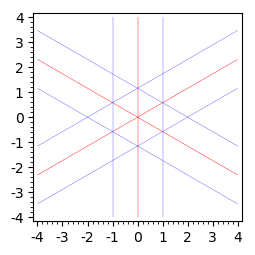

In [4]:
def plot_quiver_stability_space(QR,v,lvl=1):
    """
    This is actually unique to affine A_2...
    """
    assert QR.rk == 4; "must be framed 2d affine quiver, e.g. framed affine A_2"
    bound = max(v) + 2
    R = [a for a in QR.R_v(v) if a[0] == 0]
    Rp = [a[1:] for a in R if gcd(a) == 1] #removed reducancy
    Rpp = [a for a in Rp if QR.has_connected_support(tuple(vector(v) - vector([0] + a)))]
    Rppp = [(t[0], [t[1] - t[0], t[2] - t[0]]) for t in Rpp] # break into kδ + finite root
    for (k,a) in Rppp:
        if list(a) in [[0,1],[0,-1],[1,0],[-1,0]]:
            root_to_max_stratum_dimension(QR,v,k,a)
    # e_1 = (1,0), e2 = (-1/2, sqrt(3)/2)
    finite_root_coords = lambda a : (a[0] - 0.5*a[1], N(sqrt(3))*0.5*a[1])
    var("θ1, θ2")
    print(Rppp)
    eq = lambda a,k : a[0]*θ1 + a[1]*θ2 + k
    k_zero_red = sum(implicit_plot(eq(finite_root_coords(a), k) , (θ1, -bound,bound), (θ2, -bound,bound), linewidth = 0.3, color = 'red' ) for (k,a) in Rppp if k == 0)
    k_non_zero_blue = sum(implicit_plot(eq(finite_root_coords(a), k) , (θ1, -bound,bound), (θ2, -bound,bound), linewidth = 0.2, color = 'blue' ) for (k,a) in Rppp if k != 0)
    return(k_zero_red + k_non_zero_blue)

def root_to_max_stratum_dimension(QR,v, k, a):
    assert list(a) in [[0,1],[0,-1],[1,0],[-1,0]]; 'only want these ones'
    simple_dim = (k, k+a[0], k+a[1])
    if a[1] == 0:
        θ = (1 + a[0]*k - 3*sum(v), -a[0]*k, 3*sum(v))
    else:
        θ = (1 + a[1]*k - 3*sum(v), 3*sum(v),-a[1]*k)
    unframedθ = QR.unframed_stab(v, θ)
    strata = QR.decompositions(unframedθ, v)
    dms = [(st, QR.stratum_dimension(st)) for st in strata]
    print(f"v = {v},simple = {simple_dim}, θ = {θ}, stratadims = \n{dms}")
    dmv = QR.stratum_dimension([(v, 1)])
    for (st,dim) in dms:
        if dim == dmv -2:
            clr_print(f"stratum{st} has divisorial dim {dim}", 'red')
        
    
    
    
    
#finite_root_coords = lambda a : (a[0] - 0.5*a[1], N(sqrt(3))*a[1])
#point((1,0)) + point((-1/2, sqrt(3)/2))
#sum(point(finite_root_coords(a)) for a in [(1,0),(0,1),(1,1),(2,1), (-1,0),(-1,-1)])
C = Matrix([[2,-1,0,0],[-1,2,-1,-1], [0,-1,2,-1], [0,-1,-1,2]])
Cnf = Matrix([[2,-1,-1],[-1,2,-1],[-1,-1,2]])
QR = QuiverRoots(C)
vs = [(1,4,3,3),(1,3,3,3), (1,3,4,3)]
dm = lambda v : QR.stratum_dimension([(v, 1)])
finite_coroot_coords = lambda a : (a[0], (a[1] + 0.5*a[0])*2/N(sqrt(3)))
for v in vs:
    size_print(f"v = {v}", '3em')
    print(f"dimension = {dm(v)}")
    print(f"Cnf . v = {(Cnf*vector((v[1:])))[1:]}")
    supposed_center = finite_coroot_coords((-Cnf*vector((v[1:])))[1:])
    #pts = sum(point((finite_coroot_coords((a,b)))) for (a,b) in [(1,0),(0,1)])
    pt = point(supposed_center, color='green', size = 30)
    dim = dm(v)
    if dim >0:
        show(plot_quiver_stability_space(QR,v) + pt,figsize = 10)
        print(f"corresponding nδ = {(1,dim/2, dim/2, dim/2)}:")
        show(plot_quiver_stability_space(QR,(1,dim/2, dim/2, dim/2)),figsize = 4)


In [23]:
C = Matrix([[2,-1,0],[-1,2,-2],[0,-2,2]])
QR = QuiverRoots(C)
v = (1,4,6)
θ = (1,0)
θ11 = (1,1)
stab = QR.unframed_stab(v,θ)
#print(f"stab = {stab}")
#list(QR.Σ_θ_v(stab,v))
#list(QR.uncollected_decompositions(stab,v))
#list(QR.completely_collected_decompositions(stab,v))
#for dc in QR.completely_collected_decompositions(stab,v):
#    print(f"decomp = {dc}, dim = {QR.stratum_dimension(dc)}")
#print('done')
#QR.p((0,1,1))
#QR.stratum_dimension([((0,1,1), 1), ((0,1,1), 1), ((0,1,1),1), ((1,0,0),1)])
for a in range(8):
    for b in range(8):
        mdim = 0
        mdim11 = 0
        v = (1,a,b)
        print(f"v = {v}, decomps with θ = {θ11}:\n")
        stab11 = QR.unframed_stab(v,θ11)
        for dc in QR.completely_collected_decompositions(stab11,v):
            dim = QR.stratum_dimension(dc)
            mdim11 = max(mdim11, dim)
            print(f"decomp = {dc}, dim = {dim}")
        print(f"v = {v} decompositions with θ = {θ}:\n")
        stab = QR.unframed_stab(v,θ)
        for dc in QR.completely_collected_decompositions(stab,v):
            dim = QR.stratum_dimension(dc)
            print(f"decomp = {dc}, dim = {dim}")
            mdim = mdim if dim == mdim11 else max(mdim, dim)
        if mdim11 == mdim + 2:
            clr_print(f"divisorial? \n max for generic θ: {mdim11}\n max for non-gen {mdim}\n", 'red')
        print("---------------------------")
QR.decompositions(stab,v)

v = (1, 0, 0), decomps with θ = (1, 1):

decomp = [((1, 0, 0), 1)], dim = 0
v = (1, 0, 0) decompositions with θ = (1, 0):

decomp = [((1, 0, 0), 1)], dim = 0
---------------------------
v = (1, 0, 1), decomps with θ = (1, 1):

v = (1, 0, 1) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 1), ((1, 0, 0), 1)], dim = 0
---------------------------
v = (1, 0, 2), decomps with θ = (1, 1):

v = (1, 0, 2) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 2), ((1, 0, 0), 1)], dim = 0
---------------------------
v = (1, 0, 3), decomps with θ = (1, 1):

v = (1, 0, 3) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 3), ((1, 0, 0), 1)], dim = 0
---------------------------
v = (1, 0, 4), decomps with θ = (1, 1):

v = (1, 0, 4) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 4), ((1, 0, 0), 1)], dim = 0
---------------------------
v = (1, 0, 5), decomps with θ = (1, 1):

v = (1, 0, 5) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 5), ((1, 0, 0), 1)], dim = 0
-------

<span style="color:red">divisorial? 
 max for generic θ: 2
 max for non-gen 0
</span>

---------------------------
v = (1, 1, 2), decomps with θ = (1, 1):

decomp = [((1, 1, 2), 1)], dim = 0
v = (1, 1, 2) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 2), ((1, 1, 0), 1)], dim = 0
decomp = [((0, 0, 1), 1), ((1, 1, 1), 1)], dim = 2
---------------------------
v = (1, 1, 3), decomps with θ = (1, 1):

v = (1, 1, 3) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 3), ((1, 1, 0), 1)], dim = 0
decomp = [((0, 0, 1), 2), ((1, 1, 1), 1)], dim = 2
---------------------------
v = (1, 1, 4), decomps with θ = (1, 1):

v = (1, 1, 4) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 4), ((1, 1, 0), 1)], dim = 0
decomp = [((0, 0, 1), 3), ((1, 1, 1), 1)], dim = 2
---------------------------
v = (1, 1, 5), decomps with θ = (1, 1):

v = (1, 1, 5) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 5), ((1, 1, 0), 1)], dim = 0
decomp = [((0, 0, 1), 4), ((1, 1, 1), 1)], dim = 2
---------------------------
v = (1, 1, 6), decomps with θ = (1, 1):

v = (1, 1, 6) decomposit

<span style="color:red">divisorial? 
 max for generic θ: 2
 max for non-gen 0
</span>

---------------------------
v = (1, 2, 2), decomps with θ = (1, 1):

decomp = [((1, 2, 2), 1)], dim = 4
v = (1, 2, 2) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 1), ((1, 2, 1), 1)], dim = 2
decomp = [((1, 2, 2), 1)], dim = 4


<span style="color:red">divisorial? 
 max for generic θ: 4
 max for non-gen 2
</span>

---------------------------
v = (1, 2, 3), decomps with θ = (1, 1):

decomp = [((1, 2, 3), 1)], dim = 2
v = (1, 2, 3) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 2), ((1, 2, 1), 1)], dim = 2
decomp = [((0, 0, 1), 1), ((1, 2, 2), 1)], dim = 4
---------------------------
v = (1, 2, 4), decomps with θ = (1, 1):

v = (1, 2, 4) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 3), ((1, 2, 1), 1)], dim = 2
decomp = [((0, 0, 1), 2), ((1, 2, 2), 1)], dim = 4
---------------------------
v = (1, 2, 5), decomps with θ = (1, 1):

v = (1, 2, 5) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 4), ((1, 2, 1), 1)], dim = 2
decomp = [((0, 0, 1), 3), ((1, 2, 2), 1)], dim = 4
---------------------------
v = (1, 2, 6), decomps with θ = (1, 1):

v = (1, 2, 6) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 5), ((1, 2, 1), 1)], dim = 2
decomp = [((0, 0, 1), 4), ((1, 2, 2), 1)], dim = 4
---------------------------
v = (1, 2, 7), decomps with θ = (1, 1):

v = (1, 2, 7) decomposit

<span style="color:red">divisorial? 
 max for generic θ: 6
 max for non-gen 4
</span>

---------------------------
v = (1, 3, 4), decomps with θ = (1, 1):

decomp = [((1, 3, 4), 1)], dim = 4
v = (1, 3, 4) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 2), ((1, 3, 2), 1)], dim = 4
decomp = [((0, 0, 1), 1), ((1, 3, 3), 1)], dim = 6
---------------------------
v = (1, 3, 5), decomps with θ = (1, 1):

v = (1, 3, 5) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 3), ((1, 3, 2), 1)], dim = 4
decomp = [((0, 0, 1), 2), ((1, 3, 3), 1)], dim = 6
---------------------------
v = (1, 3, 6), decomps with θ = (1, 1):

v = (1, 3, 6) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 4), ((1, 3, 2), 1)], dim = 4
decomp = [((0, 0, 1), 3), ((1, 3, 3), 1)], dim = 6
---------------------------
v = (1, 3, 7), decomps with θ = (1, 1):

v = (1, 3, 7) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 5), ((1, 3, 2), 1)], dim = 4
decomp = [((0, 0, 1), 4), ((1, 3, 3), 1)], dim = 6
---------------------------
v = (1, 4, 0), decomps with θ = (1, 1):

v = (1, 4, 0) decomposit

<span style="color:red">divisorial? 
 max for generic θ: 8
 max for non-gen 6
</span>

---------------------------
v = (1, 4, 5), decomps with θ = (1, 1):

decomp = [((1, 4, 5), 1)], dim = 6
v = (1, 4, 5) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 3), ((1, 4, 2), 1)], dim = 0
decomp = [((0, 0, 1), 2), ((1, 4, 3), 1)], dim = 6
decomp = [((0, 0, 1), 1), ((1, 4, 4), 1)], dim = 8
---------------------------
v = (1, 4, 6), decomps with θ = (1, 1):

decomp = [((1, 4, 6), 1)], dim = 0
v = (1, 4, 6) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 4), ((1, 4, 2), 1)], dim = 0
decomp = [((0, 0, 1), 3), ((1, 4, 3), 1)], dim = 6
decomp = [((0, 0, 1), 2), ((1, 4, 4), 1)], dim = 8
---------------------------
v = (1, 4, 7), decomps with θ = (1, 1):

v = (1, 4, 7) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 5), ((1, 4, 2), 1)], dim = 0
decomp = [((0, 0, 1), 4), ((1, 4, 3), 1)], dim = 6
decomp = [((0, 0, 1), 3), ((1, 4, 4), 1)], dim = 8
---------------------------
v = (1, 5, 0), decomps with θ = (1, 1):

v = (1, 5, 0) decompositions with θ = (1, 0):

-------

<span style="color:red">divisorial? 
 max for generic θ: 2
 max for non-gen 0
</span>

---------------------------
v = (1, 5, 4), decomps with θ = (1, 1):

decomp = [((1, 5, 4), 1)], dim = 8
v = (1, 5, 4) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 1), ((1, 5, 3), 1)], dim = 2
decomp = [((1, 5, 4), 1)], dim = 8
---------------------------
v = (1, 5, 5), decomps with θ = (1, 1):

decomp = [((1, 5, 5), 1)], dim = 10
v = (1, 5, 5) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 2), ((1, 5, 3), 1)], dim = 2
decomp = [((0, 0, 1), 1), ((1, 5, 4), 1)], dim = 8
decomp = [((1, 5, 5), 1)], dim = 10


<span style="color:red">divisorial? 
 max for generic θ: 10
 max for non-gen 8
</span>

---------------------------
v = (1, 5, 6), decomps with θ = (1, 1):

decomp = [((1, 5, 6), 1)], dim = 8
v = (1, 5, 6) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 3), ((1, 5, 3), 1)], dim = 2
decomp = [((0, 0, 1), 2), ((1, 5, 4), 1)], dim = 8
decomp = [((0, 0, 1), 1), ((1, 5, 5), 1)], dim = 10
---------------------------
v = (1, 5, 7), decomps with θ = (1, 1):

decomp = [((1, 5, 7), 1)], dim = 2
v = (1, 5, 7) decompositions with θ = (1, 0):

decomp = [((0, 0, 1), 4), ((1, 5, 3), 1)], dim = 2
decomp = [((0, 0, 1), 3), ((1, 5, 4), 1)], dim = 8
decomp = [((0, 0, 1), 2), ((1, 5, 5), 1)], dim = 10
---------------------------
v = (1, 6, 0), decomps with θ = (1, 1):

v = (1, 6, 0) decompositions with θ = (1, 0):

---------------------------
v = (1, 6, 1), decomps with θ = (1, 1):

v = (1, 6, 1) decompositions with θ = (1, 0):

---------------------------
v = (1, 6, 2), decomps with θ = (1, 1):

v = (1, 6, 2) decompositions with θ = (1, 0):

---------------------------
v = (1, 6, 3),

<span style="color:red">divisorial? 
 max for generic θ: 12
 max for non-gen 10
</span>

---------------------------
v = (1, 6, 7), decomps with θ = (1, 1):



KeyboardInterrupt: 

# FINDING ALL DIVISORIAL CONTRACTIONS

In [129]:
C = Matrix([[2,-1,0],[-1,2,-2],[0,-2,2]])
QR = QuiverRoots(C)
for a in range(8):
    for b in range(8):
        v = (1,a,b)
        rts = QR.R_v(v)
        unframed_rts = [r for r in rts if r[0] == 0]
        θs = list(set([(-r[2], r[1]) for r in unframed_rts]))
        dimv = QR.stratum_dimension([(v,1)])
        if(dimv > 0):
            print(f"v = {v}\n dim(v) = {dimv}")
            #print(f"θs = {θs}")
            counter = 0
            for k in range(len(unframed_rts)):
                if( reduce(gcd, list(θs[k])) == 1):
                    if θs[k] in [(-1,0),(0,1),(0,-1)]:
                        clr = 'green'
                    else:
                        clr = 'black'
                    clr_print(f"testing θ = {θs[k]}",clr)
                    decomps = QR.decompositions(QR.unframed_stab(v, θs[k]),v)
                    if len(decomps) > 0:
                        print("there is a decomposition")
                    for dc in decomps:
                        dimr = QR.stratum_dimension(dc)
                        if dimr == dimv-2:
                            clr_print(f"statum {dc}, dim(base) = {dimr}",'red')
                            clr_print("divisorial?", "red")
                        if dimr == dimv:
                            clr = 'blue' if len(dc)> 1 else 'black'
                            clr_print(f"stratum {dc} has base dim {dimr} == dimv = {dimv}", clr)
                        if dimr > dimv:
                            clr_print(f"there is also stratum {dc} with base dim {dimr} > {dimv}  = dimv", 'purple')
            print("-------------------")

v = (1, 1, 1)
 dim(v) = 2


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 1, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((1, 0, 0), 1), ((0, 1, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:red">statum [((0, 0, 1), 1), ((1, 1, 0), 1)], dim(base) = 0</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 1, 1), 1)] has base dim 2 == dimv = 2</span>

-------------------
v = (1, 2, 1)
 dim(v) = 2


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 1), ((1, 1, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((1, 1, 0), 1), ((0, 1, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 1), 1), ((1, 0, 0), 1)], dim(base) = 0</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 2, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 2, 1), 1)] has base dim 2 == dimv = 2</span>

-------------------
v = (1, 2, 2)
 dim(v) = 4


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 2, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 0, 0), 1), ((0, 1, 1), 2)], dim(base) = 2</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 0, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 2, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:red">statum [((0, 0, 1), 1), ((1, 2, 1), 1)], dim(base) = 2</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 2, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 2, 2), 1)] has base dim 4 == dimv = 4</span>

-------------------
v = (1, 2, 3)
 dim(v) = 2


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 2, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 2), 1), ((1, 1, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 0, 1), 2), ((1, 2, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:purple">there is also stratum [((0, 0, 1), 1), ((1, 2, 2), 1)] with base dim 4 > 2  = dimv</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 2, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 3), 1), ((1, 0, 0), 1)], dim(base) = 0</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 2, 3), 1)] has base dim 2 == dimv = 2</span>

-------------------
v = (1, 3, 2)
 dim(v) = 4


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 1), ((1, 2, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 1, 0), 1), ((0, 1, 1), 2)], dim(base) = 2</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 1, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 1), 1), ((1, 1, 1), 1)], dim(base) = 2</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 3, 2), 1)] has base dim 4 == dimv = 4</span>

-------------------
v = (1, 3, 3)
 dim(v) = 6


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 0, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1)], dim(base) = 4</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 0, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:red">statum [((0, 0, 1), 1), ((1, 3, 2), 1)], dim(base) = 4</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

-------------------
v = (1, 3, 4)
 dim(v) = 4


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 2), 1), ((1, 2, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 0, 1), 2), ((1, 3, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:purple">there is also stratum [((0, 0, 1), 1), ((1, 3, 3), 1)] with base dim 6 > 4  = dimv</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 3, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 3), 1), ((1, 1, 1), 1)], dim(base) = 2</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 3, 4), 1)] has base dim 4 == dimv = 4</span>

-------------------
v = (1, 4, 3)
 dim(v) = 6


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 1), ((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 1, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1)], dim(base) = 4</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 1, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 1), 1), ((1, 2, 2), 1)], dim(base) = 4</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

-------------------
v = (1, 4, 4)
 dim(v) = 8


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 0, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1), ((0, 1, 1), 1)], dim(base) = 6</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 0, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:red">statum [((0, 0, 1), 1), ((1, 4, 3), 1)], dim(base) = 6</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

-------------------
v = (1, 4, 5)
 dim(v) = 6


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 2), 1), ((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 0, 1), 2), ((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:purple">there is also stratum [((0, 0, 1), 1), ((1, 4, 4), 1)] with base dim 8 > 6  = dimv</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 3), 1), ((1, 2, 2), 1)], dim(base) = 4</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

-------------------
v = (1, 5, 3)
 dim(v) = 2


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 3), ((1, 2, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:purple">there is also stratum [((0, 1, 0), 2), ((1, 3, 3), 1)] with base dim 6 > 2  = dimv</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 3, 2), 1), ((1, 2, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 2, 1), 2), ((1, 1, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:purple">there is also stratum [((0, 2, 1), 1), ((1, 3, 2), 1)] with base dim 4 > 2  = dimv</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:red">statum [((0, 4, 3), 1), ((1, 1, 0), 1)], dim(base) = 0</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 5, 3), 1)] has base dim 2 == dimv = 2</span>

-------------------
v = (1, 5, 4)
 dim(v) = 8


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 1), ((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 1, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1), ((0, 1, 1), 1)], dim(base) = 6</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 1, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 1), 1), ((1, 3, 3), 1)], dim(base) = 6</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

-------------------
v = (1, 5, 5)
 dim(v) = 10


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 0, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)], dim(base) = 8</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 0, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:red">statum [((0, 0, 1), 1), ((1, 5, 4), 1)], dim(base) = 8</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

-------------------
v = (1, 5, 6)
 dim(v) = 8


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 2), 1), ((1, 4, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 0, 1), 2), ((1, 5, 4), 1)] has base dim 8 == dimv = 8</span>

<span style="color:purple">there is also stratum [((0, 0, 1), 1), ((1, 5, 5), 1)] with base dim 10 > 8  = dimv</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-6, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 3), 1), ((1, 3, 3), 1)], dim(base) = 6</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 6), 1)] has base dim 8 == dimv = 8</span>

-------------------
v = (1, 5, 7)
 dim(v) = 2


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 7), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 7), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 2), 3), ((1, 2, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:purple">there is also stratum [((0, 1, 2), 2), ((1, 3, 3), 1)] with base dim 6 > 2  = dimv</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 0, 1), 4), ((1, 5, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:purple">there is also stratum [((0, 0, 1), 3), ((1, 5, 4), 1)] with base dim 8 > 2  = dimv</span>

<span style="color:purple">there is also stratum [((0, 0, 1), 2), ((1, 5, 5), 1)] with base dim 10 > 2  = dimv</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 7), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 7), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 3, 4), 1), ((1, 2, 3), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-6, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 7), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 2, 3), 2), ((1, 1, 1), 1)] has base dim 2 == dimv = 2</span>

<span style="color:purple">there is also stratum [((0, 2, 3), 1), ((1, 3, 4), 1)] with base dim 4 > 2  = dimv</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:red">statum [((0, 4, 5), 1), ((1, 1, 2), 1)], dim(base) = 0</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 5, 7), 1)] has base dim 2 == dimv = 2</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 5, 7), 1)] has base dim 2 == dimv = 2</span>

-------------------
v = (1, 6, 4)
 dim(v) = 4


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 3), ((1, 3, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:purple">there is also stratum [((0, 1, 0), 2), ((1, 4, 4), 1)] with base dim 8 > 4  = dimv</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 3, 2), 1), ((1, 3, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 2, 1), 2), ((1, 2, 2), 1)] has base dim 4 == dimv = 4</span>

<span style="color:purple">there is also stratum [((0, 2, 1), 1), ((1, 4, 3), 1)] with base dim 6 > 4  = dimv</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 4), 1)] has base dim 4 == dimv = 4</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:red">statum [((0, 4, 3), 1), ((1, 2, 1), 1)], dim(base) = 2</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 6, 4), 1)] has base dim 4 == dimv = 4</span>

-------------------
v = (1, 6, 5)
 dim(v) = 10


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 1), ((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 1, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)], dim(base) = 8</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 1, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 1), 1), ((1, 4, 4), 1)], dim(base) = 8</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-5, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

-------------------
v = (1, 6, 6)
 dim(v) = 12


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 0, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)], dim(base) = 10</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 0, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:red">statum [((0, 0, 1), 1), ((1, 6, 5), 1)], dim(base) = 10</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-5, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-6, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

-------------------
v = (1, 6, 7)
 dim(v) = 10


<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 0, 1), 2), ((1, 6, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:purple">there is also stratum [((0, 0, 1), 1), ((1, 6, 6), 1)] with base dim 12 > 10  = dimv</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 2), 1), ((1, 5, 5), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 3), 1), ((1, 4, 4), 1)], dim(base) = 8</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-7, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-6, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-5, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 6, 7), 1)] has base dim 10 == dimv = 10</span>

-------------------
v = (1, 7, 5)
 dim(v) = 6


<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 3), ((1, 4, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:purple">there is also stratum [((0, 1, 0), 2), ((1, 5, 5), 1)] with base dim 10 > 6  = dimv</span>

<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 1)</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 3, 2), 1), ((1, 4, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 2, 1), 2), ((1, 3, 3), 1)] has base dim 6 == dimv = 6</span>

<span style="color:purple">there is also stratum [((0, 2, 1), 1), ((1, 5, 4), 1)] with base dim 8 > 6  = dimv</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-5, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:red">statum [((0, 4, 3), 1), ((1, 3, 2), 1)], dim(base) = 4</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 7, 5), 1)] has base dim 6 == dimv = 6</span>

-------------------
v = (1, 7, 6)
 dim(v) = 12


<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-6, 7)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 1, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)], dim(base) = 10</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 1, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:red">statum [((0, 2, 1), 1), ((1, 5, 5), 1)], dim(base) = 10</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-6, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:blue">stratum [((0, 1, 0), 1), ((1, 6, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-5, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 6), 1)] has base dim 12 == dimv = 12</span>

-------------------
v = (1, 7, 7)
 dim(v) = 14


<span style="color:black">testing θ = (-4, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:green">testing θ = (-1, 0)</span>

there is a decomposition


<span style="color:red">statum [((0, 0, 1), 1), ((1, 7, 6), 1)], dim(base) = 12</span>

<span style="color:red">divisorial?</span>

<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-6, 7)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-1, 1)</span>

there is a decomposition


<span style="color:red">statum [((1, 0, 0), 1), ((0, 1, 1), 2), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)], dim(base) = 12</span>

<span style="color:red">divisorial?</span>

<span style="color:blue">stratum [((1, 0, 0), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1), ((0, 1, 1), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-2, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-4, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-3, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-5, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-1, 2)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-7, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-6, 5)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:green">testing θ = (0, 1)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-2, 3)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-5, 6)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

<span style="color:black">testing θ = (-3, 4)</span>

there is a decomposition


<span style="color:black">stratum [((1, 7, 7), 1)] has base dim 14 == dimv = 14</span>

-------------------


stratum [((1, 2, 2, 1), 1)] has dim 2
vext = [1], l = 2


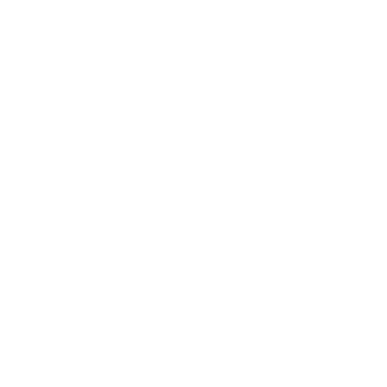

stratum [((0, 0, 1, 0), 1), ((1, 2, 1, 1), 1)] has dim 2
vext = [1, 1], l = 2


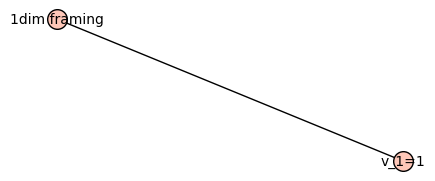

In [6]:
C = Matrix([[2,-1,0,0],[-1,2,-1,-1], [0,-1,2,-1], [0,-1,-1,2]])
Cfin = Matrix([[2,-1],[-1,2]])
QR = QuiverRoots(C)
v = (1,2,2,1)
θ = QR.unframed_stab(v, (-3,1,3))
for dc in QR.decompositions(θ, v):
    print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
    (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
    print(f"vext = {vext}, l = {l}")
    show(Q, figsize=[1,1])
θ = QR.unframed_stab(v, (-3,0,2))
for dc in QR.decompositions(θ, v):
    print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
    (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
    print(f"vext = {vext}, l = {l}")
    show(Q, figsize=[1,1])

In [22]:
C = Matrix([[2,-1,0,0],[-1,2,-1,-1], [0,-1,2,-1], [0,-1,-1,2]])
QR = QuiverRoots(C)
v = (1,4,4,4)
# orto to (1,2,2), (-, +, +) sings for θ 
θ3s = [(0,1,1), (-10,11,9),(-40/3, 11,9)]
θs = [QR.unframed_stab(v, θ3) for θ3 in θ3s]
for θ in θs:
    print(f"θ = {θ}")
    for dc in QR.decompositions(θ, v):
        print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
        (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
       print(f"vext = {vext}, l = {l}")
        show(Q, figsize=1)

[[0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 1, 1],
 [0, 1, 1, 2],
 [0, 1, 2, 1],
 [0, 1, 2, 2],
 [0, 2, 1, 1],
 [0, 2, 1, 2],
 [0, 2, 2, 1],
 [0, 2, 2, 2],
 [0, 2, 2, 3],
 [0, 2, 3, 2],
 [0, 2, 3, 3],
 [0, 3, 2, 2],
 [0, 3, 2, 3],
 [0, 3, 3, 2],
 [0, 3, 3, 3],
 [0, 3, 3, 4],
 [0, 3, 4, 3],
 [0, 3, 4, 4],
 [0, 4, 3, 3],
 [0, 4, 3, 4],
 [0, 4, 4, 3],
 [0, 4, 4, 4],
 [1, 0, 0, 0],
 [1, 1, 0, 0],
 [1, 1, 0, 1],
 [1, 1, 1, 0],
 [1, 1, 1, 1],
 [1, 1, 1, 2],
 [1, 1, 2, 1],
 [1, 1, 2, 2],
 [1, 2, 1, 1],
 [1, 2, 1, 2],
 [1, 2, 2, 1],
 [1, 2, 2, 2],
 [1, 2, 2, 3],
 [1, 2, 3, 2],
 [1, 2, 3, 3],
 [1, 3, 1, 2],
 [1, 3, 2, 1],
 [1, 3, 2, 2],
 [1, 3, 2, 3],
 [1, 3, 2, 4],
 [1, 3, 3, 2],
 [1, 3, 3, 3],
 [1, 3, 3, 4],
 [1, 3, 4, 2],
 [1, 3, 4, 3],
 [1, 3, 4, 4],
 [1, 4, 2, 2],
 [1, 4, 2, 3],
 [1, 4, 2, 4],
 [1, 4, 3, 2],
 [1, 4, 3, 3],
 [1, 4, 3, 4],
 [1, 4, 4, 2],
 [1, 4, 4, 3],
 [1, 4, 4, 4]]

<span style="font-size:6em">v = (1, 4, 4, 4)</span>

θ = (-6/5, 0, 1/10, 1/5)
stratum [((0, 1, 0, 0), 1), ((1, 3, 4, 4), 1)] has dim 4
vext = [1, 1], l = 4


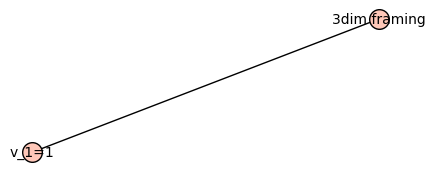

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


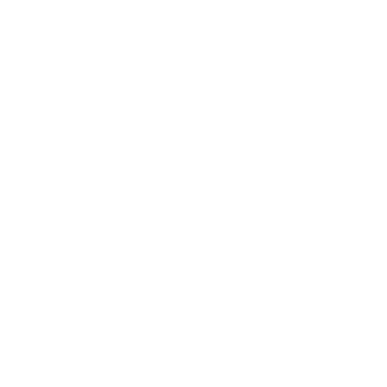

θ = (-6/5, -1/10, 1/10, 3/10)
stratum [((0, 1, 1, 0), 1), ((1, 3, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


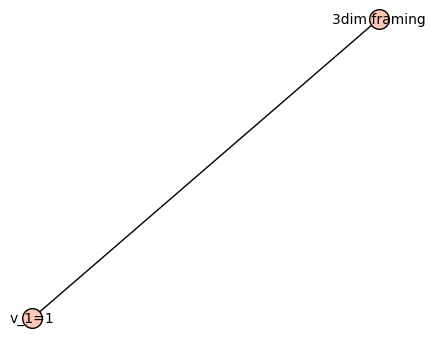

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


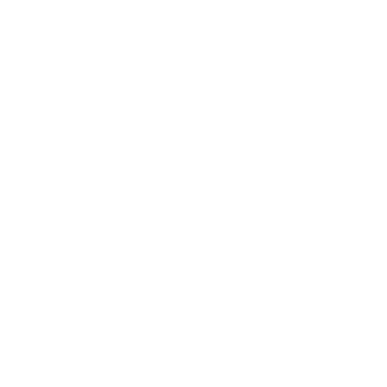

θ = (-6/5, -3/10, 1/10, 1/2)
stratum [((0, 2, 1, 1), 1), ((1, 2, 3, 3), 1)] has dim 2
vext = [1, 1], l = 2


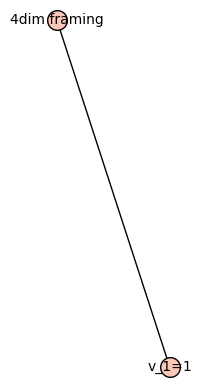

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


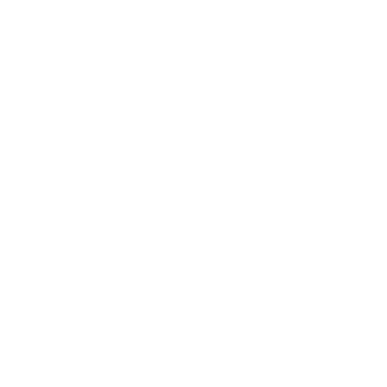

θ = (-6/5, -2/5, 1/10, 3/5)
stratum [((0, 2, 2, 1), 1), ((1, 2, 2, 3), 1)] has dim 2
vext = [1, 1], l = 2


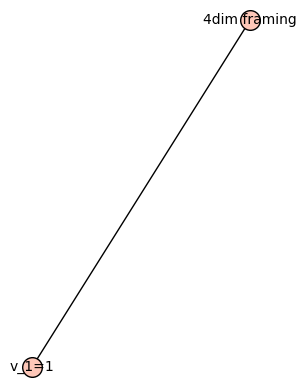

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


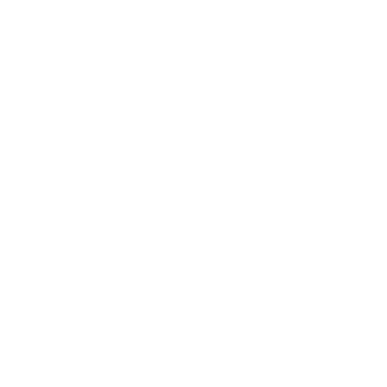

θ = (-6/5, -3/5, 1/10, 4/5)
stratum [((0, 3, 2, 2), 1), ((1, 1, 2, 2), 1)] has dim 0
vext = [1, 1], l = 0


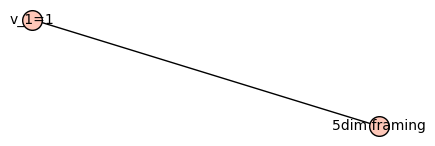

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


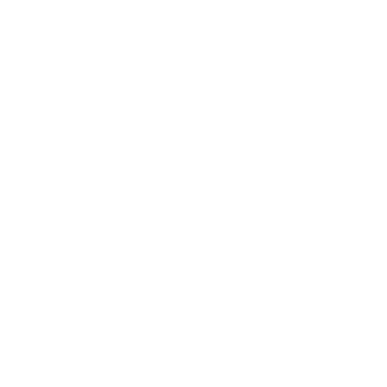

θ = (-6/5, -7/10, 1/10, 9/10)
stratum [((0, 3, 3, 2), 1), ((1, 1, 1, 2), 1)] has dim 0
vext = [1, 1], l = 0


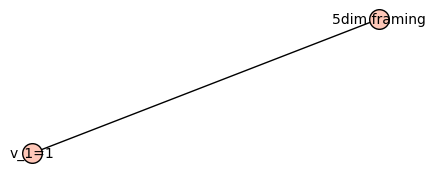

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


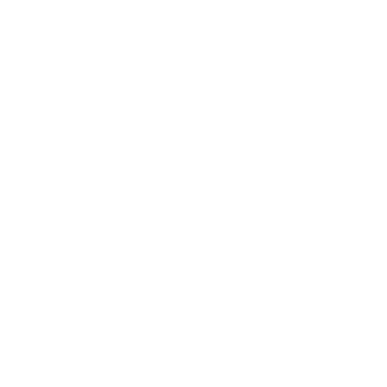

θ = (-6/5, -9/10, 1/10, 11/10)
stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


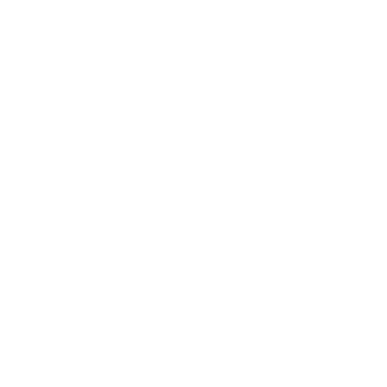

θ = (-6/5, -1, 1/10, 6/5)
stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


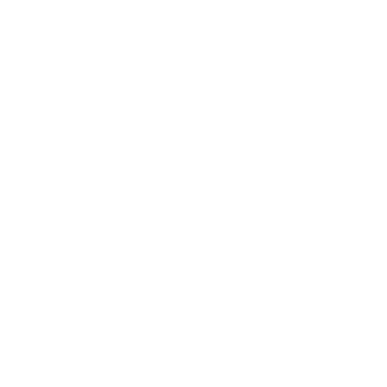

<span style="font-size:6em">v + e_i = (1, 4, 5, 4)</span>

θ = (-13/10, 0, 1/10, 1/5)
stratum [((0, 1, 0, 0), 1), ((1, 3, 5, 4), 1)] has dim 0
vext = [1, 1], l = 0


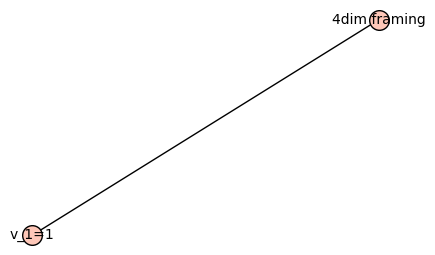

stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


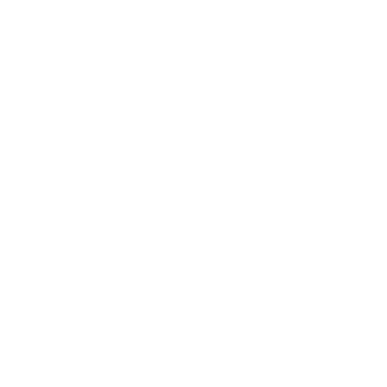

θ = (-13/10, -1/10, 1/10, 3/10)
stratum [((0, 1, 1, 0), 1), ((1, 3, 4, 4), 1)] has dim 4
vext = [1, 1], l = 4


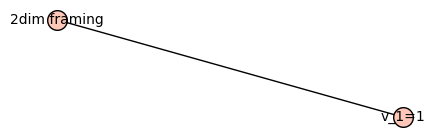

stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


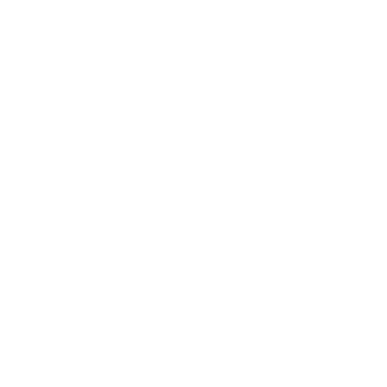

θ = (-13/10, -3/10, 1/10, 1/2)
stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


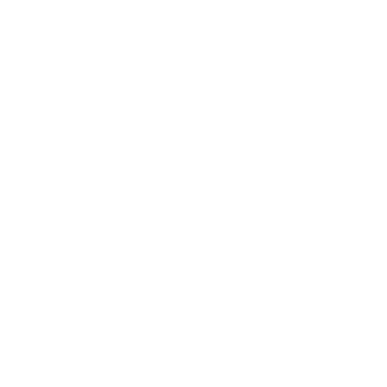

θ = (-13/10, -2/5, 1/10, 3/5)
stratum [((0, 2, 2, 1), 1), ((1, 2, 3, 3), 1)] has dim 2
vext = [1, 1], l = 2


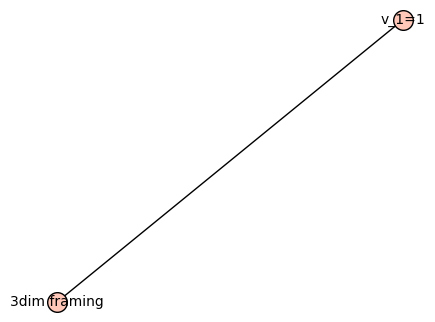

stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


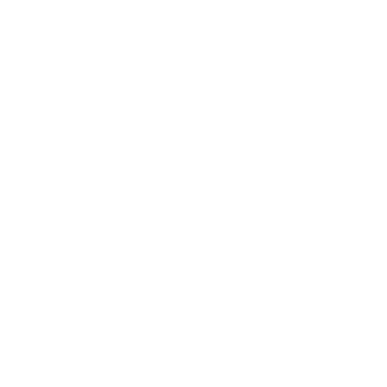

θ = (-13/10, -3/5, 1/10, 4/5)
stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


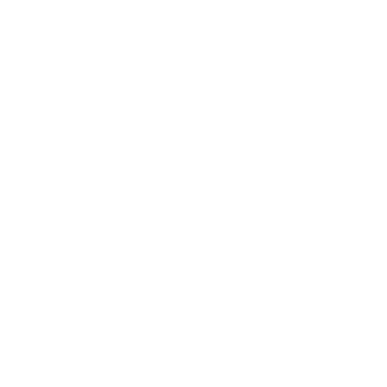

θ = (-13/10, -7/10, 1/10, 9/10)
stratum [((0, 3, 3, 2), 1), ((1, 1, 2, 2), 1)] has dim 0
vext = [1, 1], l = 0


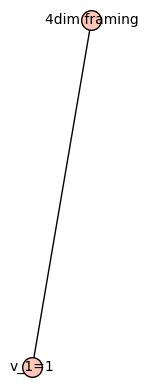

stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


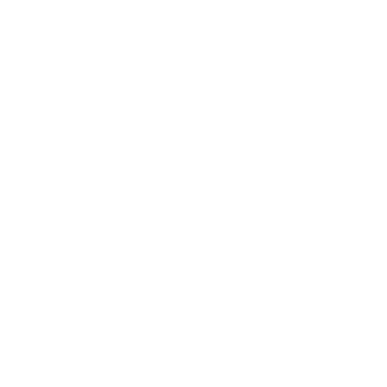

θ = (-13/10, -9/10, 1/10, 11/10)
stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


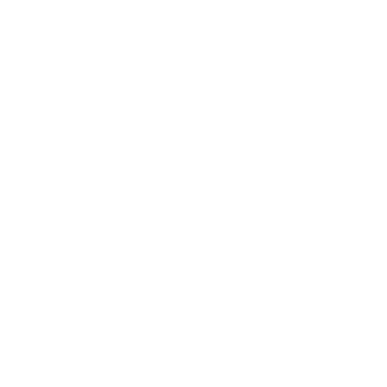

θ = (-13/10, -1, 1/10, 6/5)
stratum [((1, 4, 5, 4), 1)] has dim 6
vext = [1], l = 6


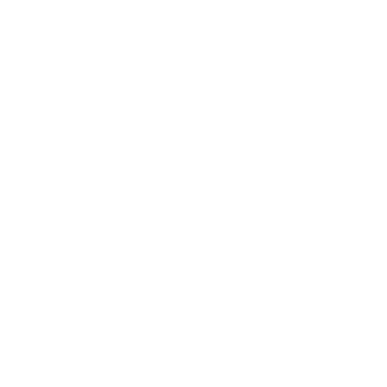

In [54]:
C = Matrix([[2,-1,0,0],[-1,2,-1,-1], [0,-1,2,-1], [0,-1,-1,2]])
QR = QuiverRoots(C)
v = (1,4,4,4)
vpi = (1,4,5,4)
# θ path is (0.1 -t, 0.1, 0.1 + t)
t = var('t')
θt = vector((1/10 - t, 1/10, 1/10 + t))
rts = [r[1:] for r in QR.R_θ_v((0,0,0,0), v) if r[0] == 0]
sdicts = [solve(θt * vector(r) == 0, t, solution_dict=True) for r in rts]
θ3s = [vector((1/10 - d[0][t], 1/10, 1/10+d[0][t])) for d in sdicts if d != [] and 1/10+d[0][t] > 0] 
θs = [QR.unframed_stab(v, θ3) for θ3 in θ3s]
size_print(f"v = {v}")
for θ in θs:
    print(f"θ = {θ}")
    for dc in QR.decompositions(θ, v):
        print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
        (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
        print(f"vext = {vext}, l = {l}")
        show(Q, figsize=[1,1])
size_print(f"v + e_i = {vpi}")
v = vpi
rts = [r[1:] for r in QR.R_θ_v((0,0,0,0), v) if r[0] == 0]
sdicts = [solve(θt * vector(r) == 0, t, solution_dict=True) for r in rts]
θ3s = [vector((1/10 - d[0][t], 1/10, 1/10+d[0][t])) for d in sdicts if d != [] and 1/10+d[0][t] > 0] 
θs = [QR.unframed_stab(v, θ3) for θ3 in θ3s]
for θ in θs:
    print(f"θ = {θ}")
    for dc in QR.decompositions(θ, v):
        print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
        (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
        print(f"vext = {vext}, l = {l}")
        show(Q, figsize=[1,1])


<span style="font-size:6em">v = (1, 4, 3, 4)</span>

θ = (-4/5, 0, 0, 1/5)
stratum [((0, 0, 1, 0), 1), ((0, 1, 0, 0), 1), ((1, 3, 2, 4), 1)] has dim 0
vext = [1, 1, 1], l = 0


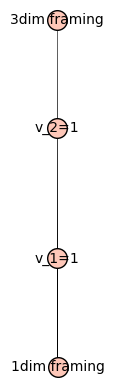

stratum [((0, 1, 0, 0), 1), ((1, 3, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


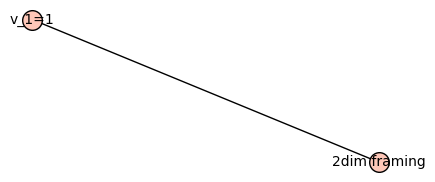

stratum [((1, 4, 3, 4), 1)] has dim 6
vext = [1], l = 6


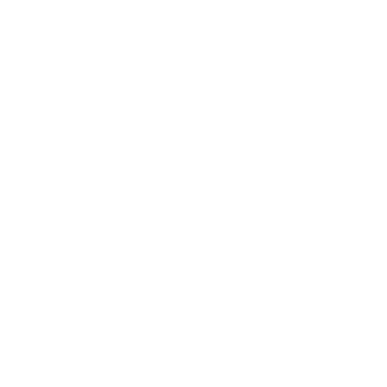

θ = (-4/5, 0, 0, 1/5)
stratum [((0, 0, 1, 0), 1), ((0, 1, 0, 0), 1), ((1, 3, 2, 4), 1)] has dim 0
vext = [1, 1, 1], l = 0


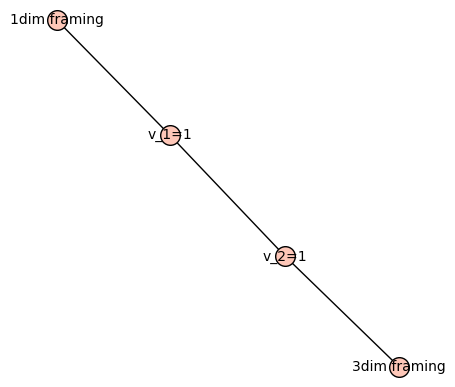

stratum [((0, 1, 0, 0), 1), ((1, 3, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


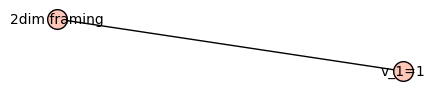

stratum [((1, 4, 3, 4), 1)] has dim 6
vext = [1], l = 6


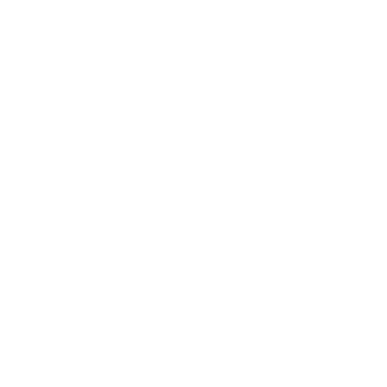

θ = (-4/5, -1/5, 0, 2/5)
stratum [((0, 0, 1, 0), 1), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 1], l = 0


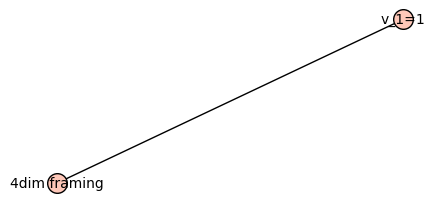

stratum [((0, 2, 1, 1), 1), ((1, 2, 2, 3), 1)] has dim 2
vext = [1, 1], l = 2


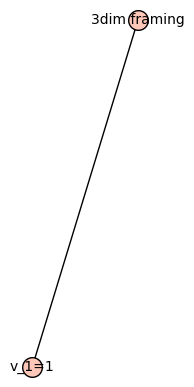

stratum [((1, 4, 3, 4), 1)] has dim 6
vext = [1], l = 6


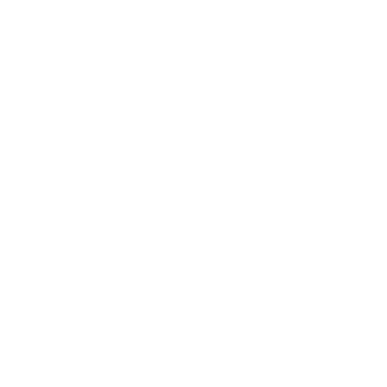

θ = (-4/5, -1/5, 0, 2/5)
stratum [((0, 0, 1, 0), 1), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 1], l = 0


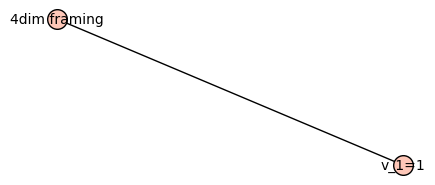

stratum [((0, 2, 1, 1), 1), ((1, 2, 2, 3), 1)] has dim 2
vext = [1, 1], l = 2


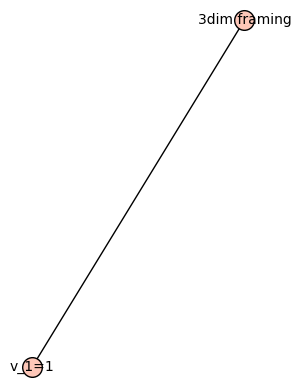

stratum [((1, 4, 3, 4), 1)] has dim 6
vext = [1], l = 6


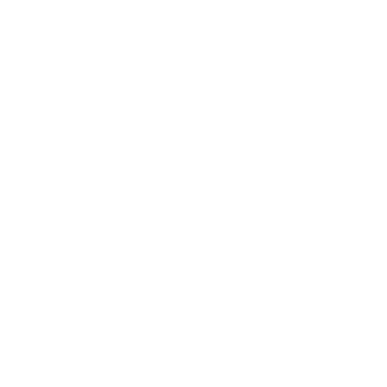

θ = (-4/5, -2/5, 0, 3/5)
stratum [((0, 0, 1, 0), 1), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 1], l = 0


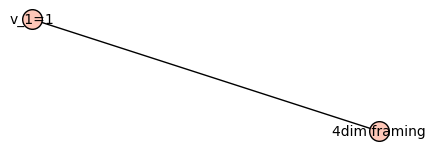

stratum [((0, 3, 2, 2), 1), ((1, 1, 1, 2), 1)] has dim 0
vext = [1, 1], l = 0


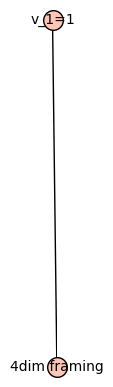

stratum [((1, 4, 3, 4), 1)] has dim 6
vext = [1], l = 6


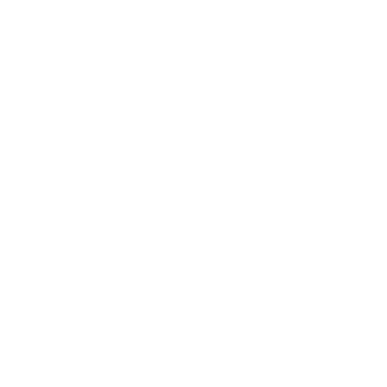

θ = (-4/5, -2/5, 0, 3/5)
stratum [((0, 0, 1, 0), 1), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 1], l = 0


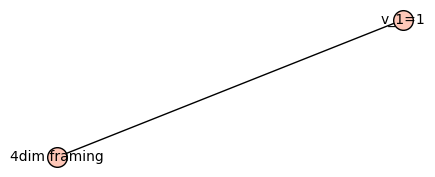

stratum [((0, 3, 2, 2), 1), ((1, 1, 1, 2), 1)] has dim 0
vext = [1, 1], l = 0


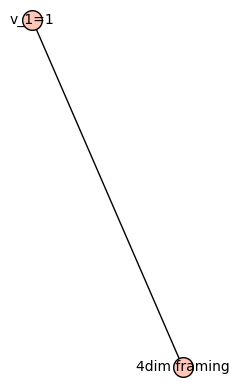

stratum [((1, 4, 3, 4), 1)] has dim 6
vext = [1], l = 6


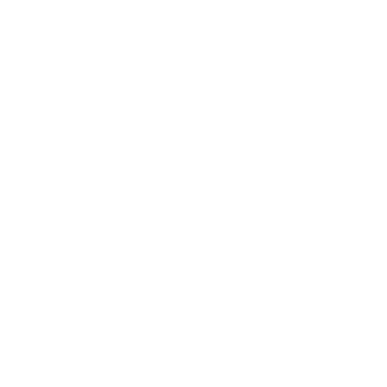

θ = (-4/5, -3/5, 0, 4/5)
stratum [((0, 0, 1, 0), 1), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 1], l = 0


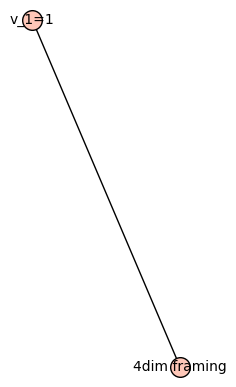

stratum [((1, 4, 3, 4), 1)] has dim 6
vext = [1], l = 6


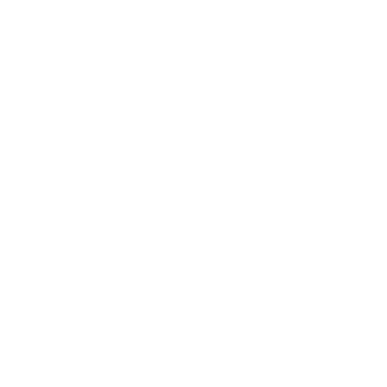

<span style="font-size:6em">v + e_i = (1, 4, 4, 4)</span>

θ = (-4/5, 0, 0, 1/5)
stratum [((0, 0, 1, 0), 2), ((0, 1, 0, 0), 1), ((1, 3, 2, 4), 1)] has dim 0
vext = [1, 1, 2], l = 0


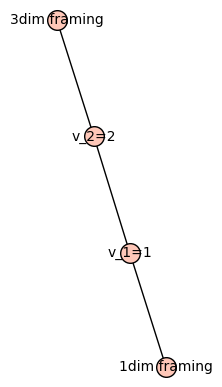

stratum [((0, 0, 1, 0), 1), ((0, 1, 0, 0), 1), ((1, 3, 3, 4), 1)] has dim 4
vext = [1, 1, 1], l = 4


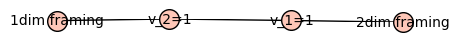

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


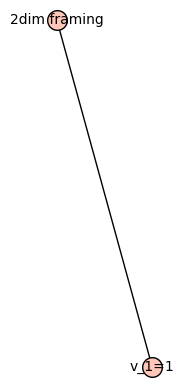

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


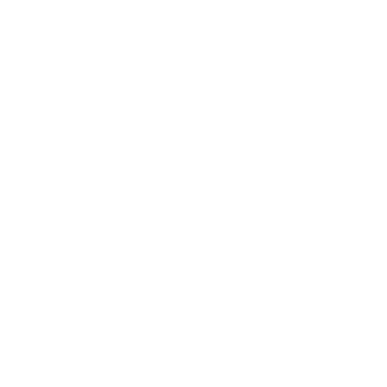

θ = (-4/5, 0, 0, 1/5)
stratum [((0, 0, 1, 0), 2), ((0, 1, 0, 0), 1), ((1, 3, 2, 4), 1)] has dim 0
vext = [1, 1, 2], l = 0


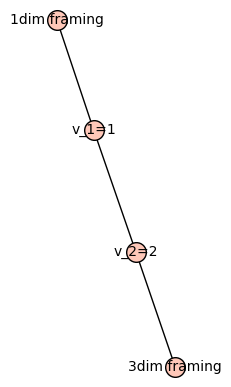

stratum [((0, 0, 1, 0), 1), ((0, 1, 0, 0), 1), ((1, 3, 3, 4), 1)] has dim 4
vext = [1, 1, 1], l = 4


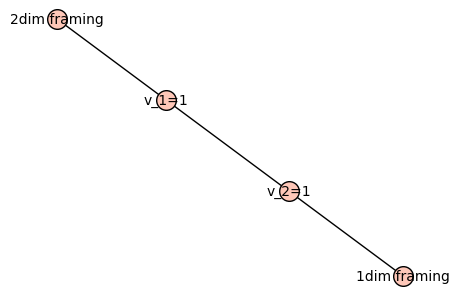

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


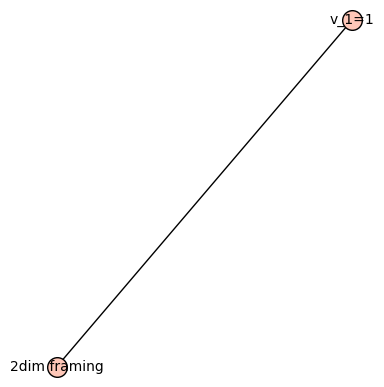

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


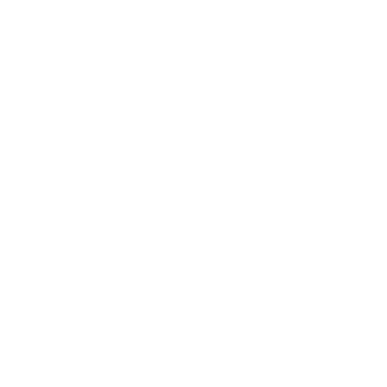

θ = (-4/5, -1/5, 0, 2/5)
stratum [((0, 0, 1, 0), 2), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 2], l = 0


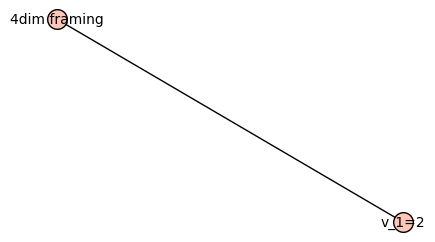

stratum [((0, 0, 1, 0), 1), ((0, 2, 1, 1), 1), ((1, 2, 2, 3), 1)] has dim 2
vext = [1, 1, 1], l = 2


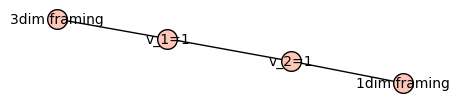

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


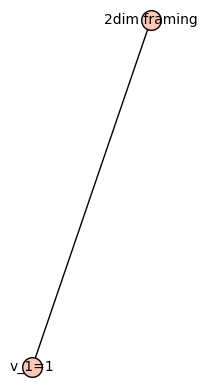

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


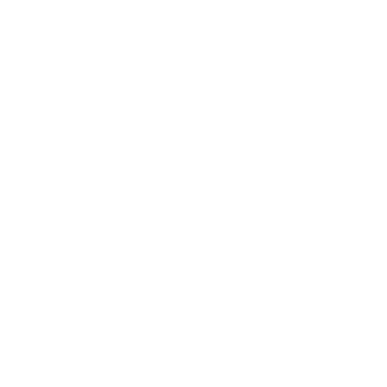

θ = (-4/5, -1/5, 0, 2/5)
stratum [((0, 0, 1, 0), 2), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 2], l = 0


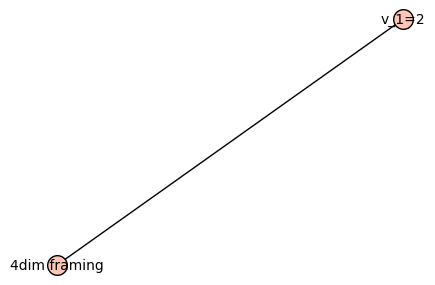

stratum [((0, 0, 1, 0), 1), ((0, 2, 1, 1), 1), ((1, 2, 2, 3), 1)] has dim 2
vext = [1, 1, 1], l = 2


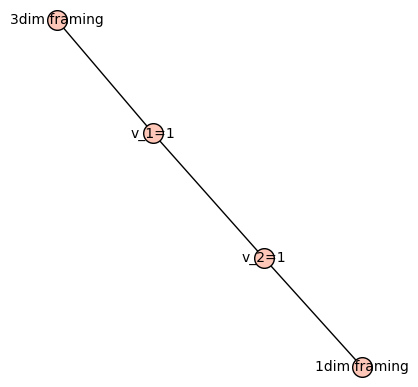

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


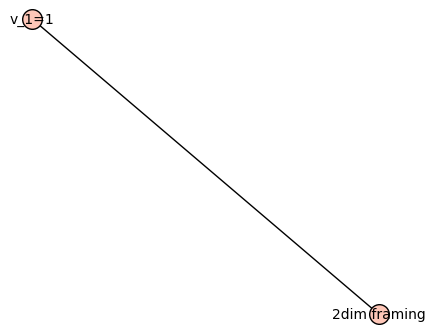

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


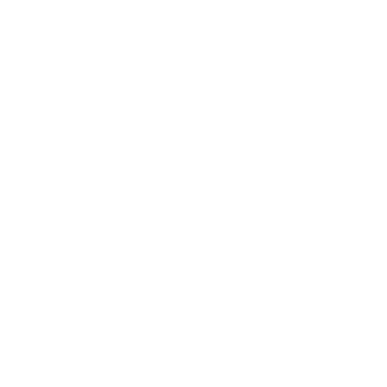

θ = (-4/5, -2/5, 0, 3/5)
stratum [((0, 0, 1, 0), 2), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 2], l = 0


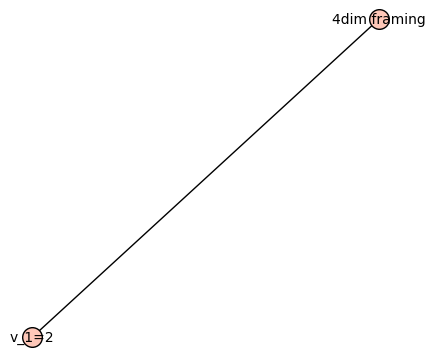

stratum [((0, 0, 1, 0), 1), ((0, 3, 2, 2), 1), ((1, 1, 1, 2), 1)] has dim 0
vext = [1, 1, 1], l = 0


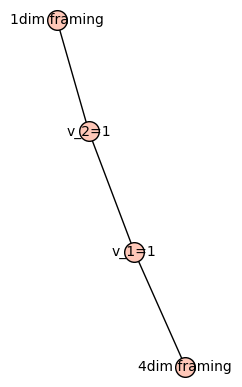

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


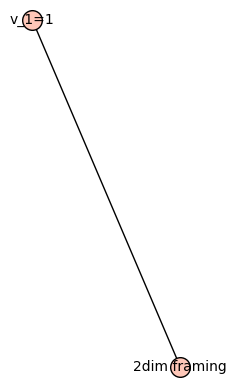

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


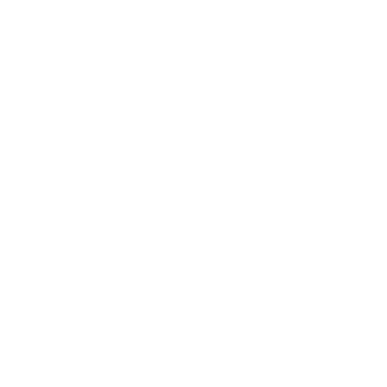

θ = (-4/5, -2/5, 0, 3/5)
stratum [((0, 0, 1, 0), 2), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 2], l = 0


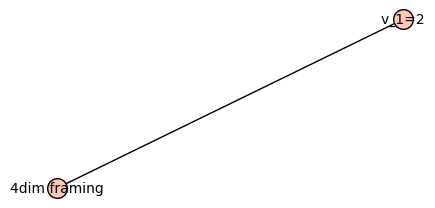

stratum [((0, 0, 1, 0), 1), ((0, 3, 2, 2), 1), ((1, 1, 1, 2), 1)] has dim 0
vext = [1, 1, 1], l = 0


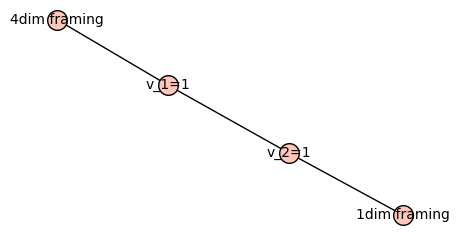

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


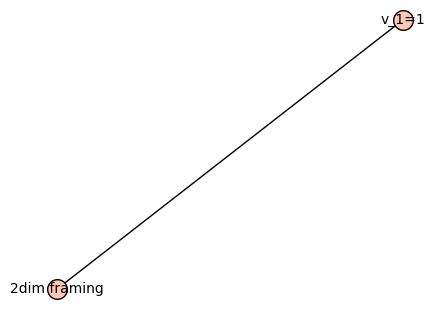

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


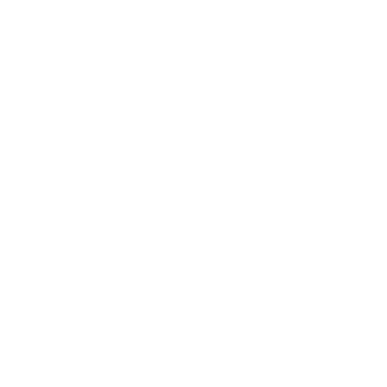

θ = (-4/5, -3/5, 0, 4/5)
stratum [((0, 0, 1, 0), 2), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 2], l = 0


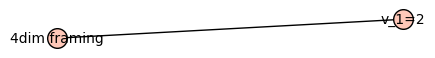

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


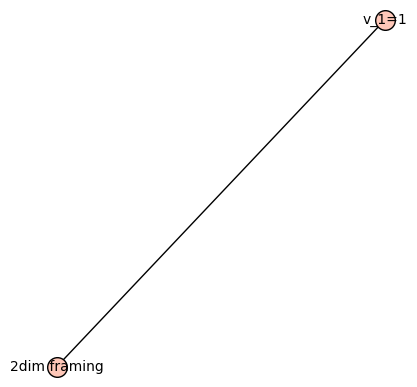

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


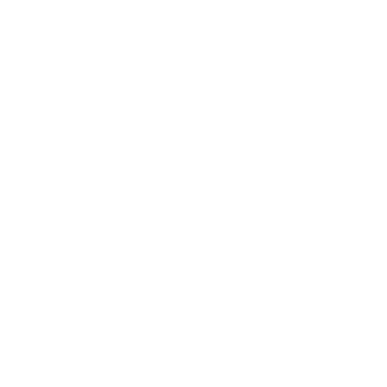

θ = (-4/5, -3/5, 0, 4/5)
stratum [((0, 0, 1, 0), 2), ((1, 4, 2, 4), 1)] has dim 0
vext = [1, 2], l = 0


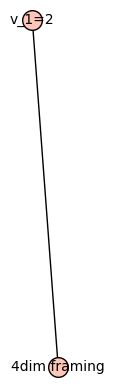

stratum [((0, 0, 1, 0), 1), ((1, 4, 3, 4), 1)] has dim 6
vext = [1, 1], l = 6


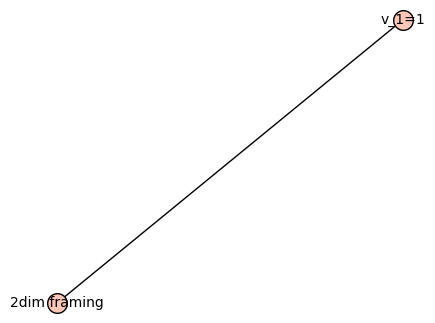

stratum [((1, 4, 4, 4), 1)] has dim 8
vext = [1], l = 8


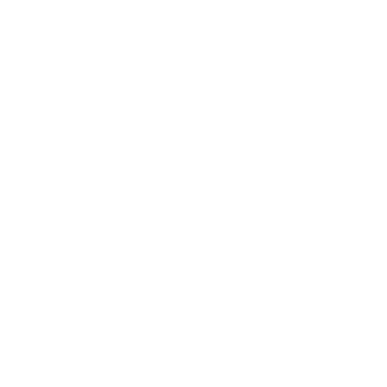

In [57]:
C = Matrix([[2,-1,0,0],[-1,2,-1,-1], [0,-1,2,-1], [0,-1,-1,2]])
QR = QuiverRoots(C)
v = (1,4,3,4)
vpi = (1,4,4,4)
# θ path is (0.1 -t, 0, 0.1 + t)
t = var('t')
θt = vector((1/10 - t, 0, 1/10 + t))
rts = [r[1:] for r in QR.R_θ_v((0,0,0,0), v) if r[0] == 0 and not (r[1] == 0 and r[3] == 0)]
sdicts = [solve(θt * vector(r) == 0, t, solution_dict=True) for r in rts]
θ3s = [vector((1/10 - d[0][t], 0, 1/10+d[0][t])) for d in sdicts if d != [] and 1/10+d[0][t] > 0] 
θs = [QR.unframed_stab(v, θ3) for θ3 in θ3s]
size_print(f"v = {v}")
for θ in θs:
    print(f"θ = {θ}")
    for dc in QR.decompositions(θ, v):
        print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
        (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
        print(f"vext = {vext}, l = {l}")
        show(Q, figsize=[1,1])
size_print(f"v + e_i = {vpi}")
v = vpi
rts = [r[1:] for r in QR.R_θ_v((0,0,0,0), v) if r[0] == 0]
sdicts = [solve(θt * vector(r) == 0, t, solution_dict=True) for r in rts]
θ3s = [vector((1/10 - d[0][t], 0, 1/10+d[0][t])) for d in sdicts if d != [] and 1/10+d[0][t] > 0] 
θs = [QR.unframed_stab(v, θ3) for θ3 in θ3s]
for θ in θs:
    print(f"θ = {θ}")
    for dc in QR.decompositions(θ, v):
        print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
        (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
        print(f"vext = {vext}, l = {l}")
        show(Q, figsize=[1,1])

<span style="font-size:4em">v = (1, 5, 4, 4)</span>

θ = (-79/100, -1/100, 0, 21/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


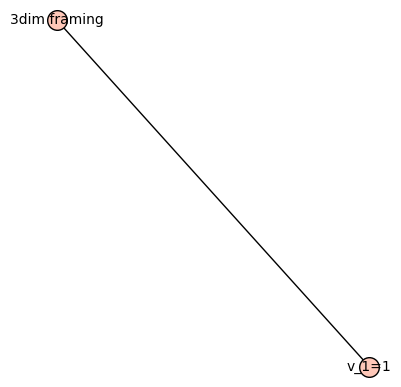

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


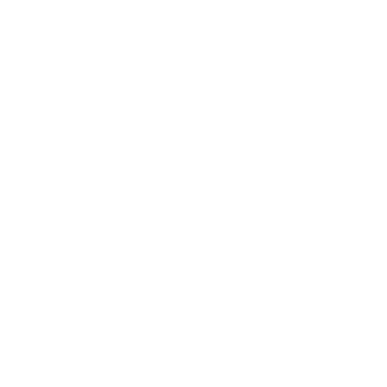

θ = (-79/100, -1/100, 0, 21/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


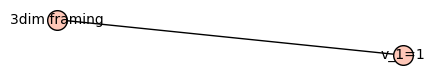

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


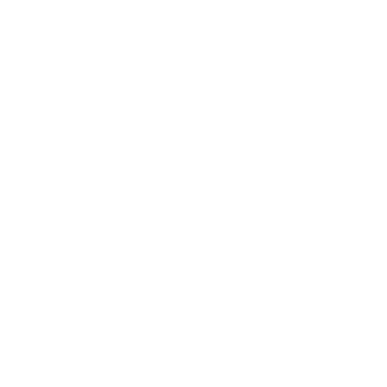

θ = (-59/100, -21/100, 0, 41/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


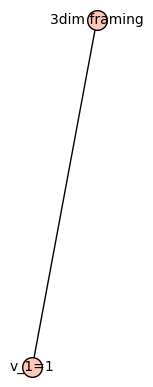

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


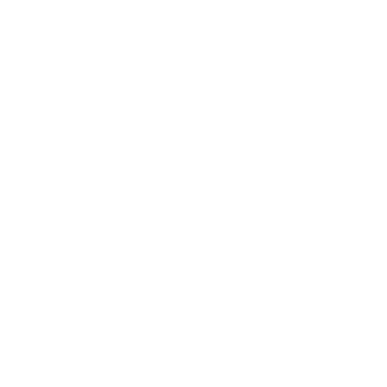

θ = (-59/100, -21/100, 0, 41/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


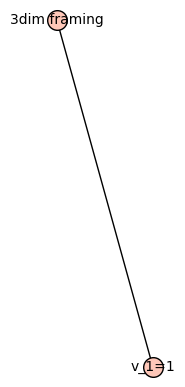

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


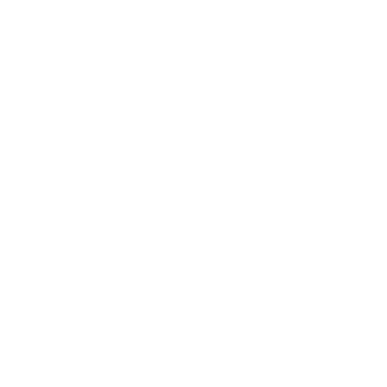

θ = (-39/100, -41/100, 0, 61/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


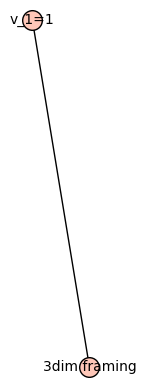

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


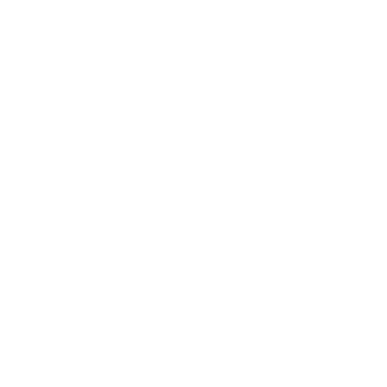

θ = (-39/100, -41/100, 0, 61/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


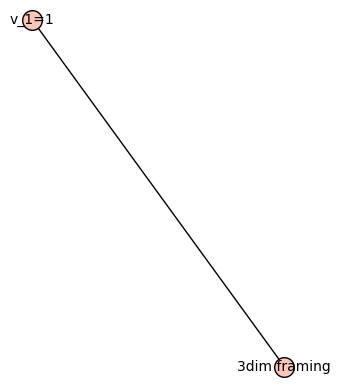

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


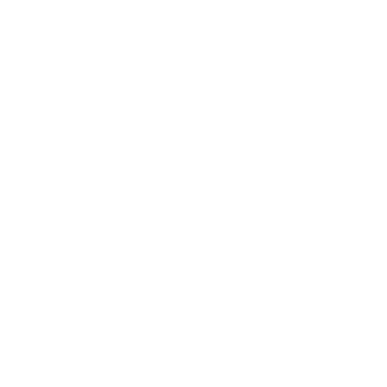

θ = (-19/100, -61/100, 0, 81/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


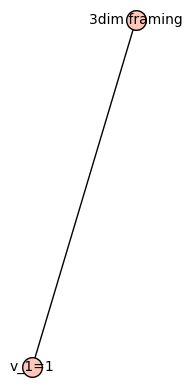

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


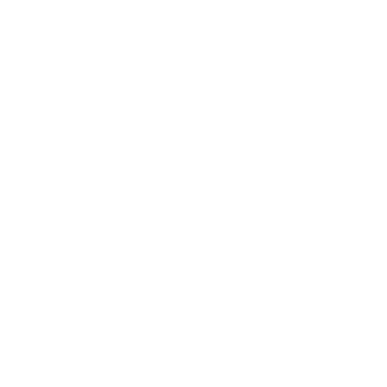

θ = (-19/100, -61/100, 0, 81/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


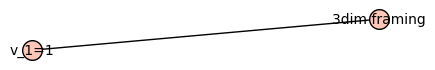

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


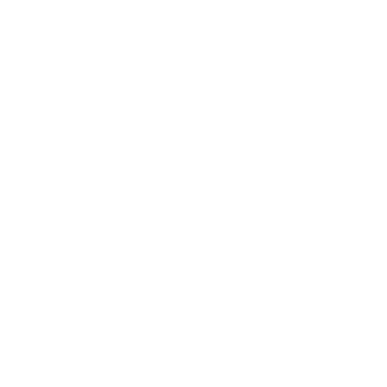

θ = (1/100, -81/100, 0, 101/100)
stratum [((0, 0, 1, 0), 1), ((1, 5, 3, 4), 1)] has dim 4
vext = [1, 1], l = 4


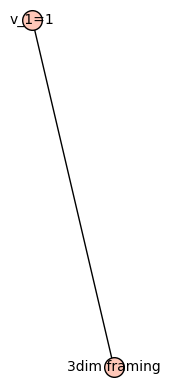

stratum [((1, 5, 4, 4), 1)] has dim 8
vext = [1], l = 8


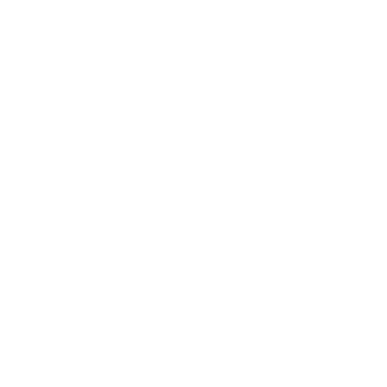

<span style="font-size:4em">v + e_i = (1, 5, 5, 4)</span>

θ = (-79/100, -1/100, 0, 21/100)


In [ ]:
C = Matrix([[2,-1,0,0],[-1,2,-1,-1], [0,-1,2,-1], [0,-1,-1,2]])
QR = QuiverRoots(C)
v = (1,5,4,4)
vpi = (1,5,5,4)
# θ path is (0.1 -t, 0, 0.1 + t)
t = var('t')
θt = vector((1/10 - t, 0, 1/10 + t))
rts = [r[1:] for r in QR.R_θ_v((0,0,0,0), v) if r[0] == 0 and not (r[1] == 0 and r[3] == 0)]
sdicts = [solve(θt * vector(r) == 0, t, solution_dict=True) for r in rts]
#we modify to be on e_1^\perp but slightly to 
# the side of the non-generic walls. Hopefully we get the same answer regardless...
θ3s = [vector((1/10 - d[0][t]-1/100, 0, 1/10+d[0][t]+1/100)) for d in sdicts if d != [] and 1/10+d[0][t] > 0] 
θs = [QR.unframed_stab(v, θ3) for θ3 in θ3s]
size_print(f"v = {v}")
for θ in θs:
    print(f"θ = {θ}")
    for dc in QR.decompositions(θ, v):
        print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
        (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
        print(f"vext = {vext}, l = {l}")
        show(Q, figsize=[1,1])
size_print(f"v + e_i = {vpi}")
v = vpi
rts = [r[1:] for r in QR.R_θ_v((0,0,0,0), v) if r[0] == 0]
sdicts = [solve(θt * vector(r) == 0, t, solution_dict=True) for r in rts]
θ3s = [vector((1/10 - d[0][t]-1/100, 0, 1/10+d[0][t]+1/100)) for d in sdicts if d != [] and 1/10+d[0][t] > 0] 
θs = [QR.unframed_stab(v, θ3) for θ3 in θ3s]
for θ in θs:
    print(f"θ = {θ}")
    for dc in QR.decompositions(θ, v):
        print(f"stratum {dc} has dim {QR.stratum_dimension(dc)}")
        (Q,vext,l,q) = QR.stratum_ext_quiver(dc, θ, [])
        print(f"vext = {vext}, l = {l}")
        show(Q, figsize=[1,1])